In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv1D,Conv2D, Dense, Flatten, MaxPooling1D, MaxPooling2D, AveragePooling2D
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import calendar
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling1D, Concatenate
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Layer, MultiHeadAttention, LayerNormalization, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import torch.optim as optim

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
#!pip install xgboost

In [4]:
#import yfinance as yf
#sp500 = "LT.NS"
#data = yf.download(sp500, start="2019-11-25", end="2024-11-25")
#data.to_csv("data/LnT_historical_data.csv")

In [5]:
df_train_all = pd.read_csv("data/LnT_historical_data.csv")

In [6]:
df_train_all

,Date,Adj_Close,Close,High,Low,Open,Volume
0,2019-11-25 00:00:00+00:00,1259.961792,1380.849976,1389.000000,1371.099976,1378.500000,2956576
1,2019-11-26 00:00:00+00:00,1243.674438,1363.000000,1380.000000,1359.550049,1379.349976,4853977
2,2019-11-27 00:00:00+00:00,1218.582153,1335.500000,1370.000000,1314.150024,1365.000000,7904745
3,2019-11-28 00:00:00+00:00,1231.721558,1349.900024,1354.000000,1327.199951,1344.000000,4503913
4,2019-11-29 00:00:00+00:00,1214.065308,1330.550049,1350.199951,1328.000000,1350.000000,2515083
...,...,...,...,...,...,...,...
1233,2024-11-14 00:00:00+00:00,3526.250000,3526.250000,3565.750000,3500.149902,3558.000000,1291765
1234,2024-11-18 00:00:00+00:00,3542.149902,3542.149902,3568.300049,3510.850098,3521.100098,1233217
1235,2024-11-19 00:00:00+00:00,3505.899902,3505.899902,3607.000000,3495.000000,3559.899902,1826460
1236,2024-11-21 00:00:00+00:00,3483.500000,3483.500000,3530.550049,3452.449951,3530.000000,1510581


In [7]:
df_train_all["Date"] = pd.to_datetime(df_train_all["Date"])

In [8]:
df_train_all.describe()

,Adj_Close,Close,High,Low,Open,Volume
count,1238.000000,1238.000000,1238.000000,1238.000000,1238.000000,1.238000e+03
mean,2008.925211,2062.823021,2085.688566,2040.985463,2063.858482,3.011686e+06
std,916.109006,894.685372,901.813680,886.812497,894.810542,2.204713e+06
min,654.971985,707.900024,755.750000,661.000000,697.200012,2.127960e+05
25%,1305.126495,1373.475006,1392.787476,1356.712494,1377.149963,1.666719e+06
50%,1791.520264,1850.674988,1871.500000,1827.625000,1849.450012,2.289248e+06
75%,2637.318298,2665.549927,2688.162476,2645.337463,2668.712463,3.616259e+06
max,3866.753906,3897.149902,3919.899902,3801.100098,3855.399902,2.115335e+07


In [9]:
df_train_all.isnull().sum()

Date         0
Adj_Close    0
Close        0
High         0
Low          0
Open         0
Volume       0
dtype: int64

In [10]:
type(df_train_all["Date"])

pandas.core.series.Series

In [11]:
df_train_all["epoch_time"]= df_train_all["Date"].apply(lambda x: x.timestamp())

In [12]:
df_train_all

,Date,Adj_Close,Close,High,Low,Open,Volume,epoch_time
0,2019-11-25 00:00:00+00:00,1259.961792,1380.849976,1389.000000,1371.099976,1378.500000,2956576,1.574640e+09
1,2019-11-26 00:00:00+00:00,1243.674438,1363.000000,1380.000000,1359.550049,1379.349976,4853977,1.574726e+09
2,2019-11-27 00:00:00+00:00,1218.582153,1335.500000,1370.000000,1314.150024,1365.000000,7904745,1.574813e+09
3,2019-11-28 00:00:00+00:00,1231.721558,1349.900024,1354.000000,1327.199951,1344.000000,4503913,1.574899e+09
4,2019-11-29 00:00:00+00:00,1214.065308,1330.550049,1350.199951,1328.000000,1350.000000,2515083,1.574986e+09
...,...,...,...,...,...,...,...,...
1233,2024-11-14 00:00:00+00:00,3526.250000,3526.250000,3565.750000,3500.149902,3558.000000,1291765,1.731542e+09
1234,2024-11-18 00:00:00+00:00,3542.149902,3542.149902,3568.300049,3510.850098,3521.100098,1233217,1.731888e+09
1235,2024-11-19 00:00:00+00:00,3505.899902,3505.899902,3607.000000,3495.000000,3559.899902,1826460,1.731974e+09
1236,2024-11-21 00:00:00+00:00,3483.500000,3483.500000,3530.550049,3452.449951,3530.000000,1510581,1.732147e+09


In [13]:
def is_last_thursday(date):
    year = date.year
    month = date.month
    
    last_day = calendar.monthrange(year, month)[1]
    last_date = datetime(year, month, last_day)
    last_day_weekday = last_date.weekday()
    days_since_last_thursday = (last_day_weekday - calendar.THURSDAY) % 7
    last_thursday_date = last_date - timedelta(days=days_since_last_thursday)
    
    return 1 if date.date() == last_thursday_date.date() else 0

In [14]:
df_train_all['opt_expiry'] = df_train_all['Date'].apply(is_last_thursday)

In [15]:
df_train_all['10DaysMA'] =  df_train_all['Adj_Close'].rolling(window=10).mean()
df_train_all['30DaysMA'] =  df_train_all['Adj_Close'].rolling(window=30).mean()
df_train_all['50DaysMA'] =  df_train_all['Adj_Close'].rolling(window=50).mean()

In [16]:
df_train_all

,Date,Adj_Close,Close,High,Low,Open,Volume,epoch_time,opt_expiry,10DaysMA,30DaysMA,50DaysMA
0,2019-11-25 00:00:00+00:00,1259.961792,1380.849976,1389.000000,1371.099976,1378.500000,2956576,1.574640e+09,0,NaN,NaN,NaN
1,2019-11-26 00:00:00+00:00,1243.674438,1363.000000,1380.000000,1359.550049,1379.349976,4853977,1.574726e+09,0,NaN,NaN,NaN
2,2019-11-27 00:00:00+00:00,1218.582153,1335.500000,1370.000000,1314.150024,1365.000000,7904745,1.574813e+09,0,NaN,NaN,NaN
3,2019-11-28 00:00:00+00:00,1231.721558,1349.900024,1354.000000,1327.199951,1344.000000,4503913,1.574899e+09,1,NaN,NaN,NaN
4,2019-11-29 00:00:00+00:00,1214.065308,1330.550049,1350.199951,1328.000000,1350.000000,2515083,1.574986e+09,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1233,2024-11-14 00:00:00+00:00,3526.250000,3526.250000,3565.750000,3500.149902,3558.000000,1291765,1.731542e+09,0,3602.230029,3526.965015,3583.747998
1234,2024-11-18 00:00:00+00:00,3542.149902,3542.149902,3568.300049,3510.850098,3521.100098,1233217,1.731888e+09,0,3593.810010,3528.571680,3582.107998
1235,2024-11-19 00:00:00+00:00,3505.899902,3505.899902,3607.000000,3495.000000,3559.899902,1826460,1.731974e+09,0,3586.955005,3529.823340,3580.730996
1236,2024-11-21 00:00:00+00:00,3483.500000,3483.500000,3530.550049,3452.449951,3530.000000,1510581,1.732147e+09,0,3577.825000,3528.193343,3578.834995


In [17]:
#df_train_all["Next_Close"] = df_train_all.shift(-1)["Close"]

In [18]:
df_train_all.dropna(subset=['50DaysMA'], inplace=True)
#df_train_all.dropna(subset=['Next_Close'], inplace=True)

In [19]:
df_train_all.isnull().sum()

Date          0
Adj_Close     0
Close         0
High          0
Low           0
Open          0
Volume        0
epoch_time    0
opt_expiry    0
10DaysMA      0
30DaysMA      0
50DaysMA      0
dtype: int64

In [20]:
df_train_all.columns

Index(['Date', 'Adj_Close', 'Close', 'High', 'Low', 'Open', 'Volume',
       'epoch_time', 'opt_expiry', '10DaysMA', '30DaysMA', '50DaysMA'],
      dtype='object')

In [21]:
#df_train_all.drop(columns=["epoch_time"], inplace=True)

In [22]:
def process_date_features(data):
    data['Date'] = pd.to_datetime(data['Date'])
    data['Day'] = data['Date'].dt.day
    data['Month'] = data['Date'].dt.month
    data['Year'] = data['Date'].dt.year
    data['DayOfWeek'] = data['Date'].dt.dayofweek
    data['IsMonthStart'] = data['Date'].dt.is_month_start.astype(int)
    data['IsMonthEnd'] = data['Date'].dt.is_month_end.astype(int)
    return data

In [54]:
df_train_all = process_date_features(df_train_all)

In [55]:
df_train_all

,Date,Adj_Close,Close,High,Low,Open,Volume,epoch_time,opt_expiry,10DaysMA,30DaysMA,50DaysMA,Day,Month,Year,DayOfWeek,IsMonthStart,IsMonthEnd
49,2020-02-03 00:00:00+00:00,1174.008667,1286.650024,1303.900024,1272.000000,1290.000000,5767353,1.580688e+09,0,1220.420581,1205.781779,1202.550188,3,2,2020,0,0,0
50,2020-02-04 00:00:00+00:00,1178.662109,1291.750000,1307.300049,1287.550049,1296.000000,3604309,1.580774e+09,0,1219.453381,1205.188688,1200.924194,4,2,2020,1,0,0
51,2020-02-05 00:00:00+00:00,1195.360229,1310.050049,1325.000000,1295.000000,1297.900024,4220104,1.580861e+09,0,1220.899646,1205.463953,1199.957910,5,2,2020,2,0,0
52,2020-02-06 00:00:00+00:00,1202.249023,1317.599976,1325.000000,1309.050049,1322.900024,2354458,1.580947e+09,0,1219.558325,1206.628845,1199.631248,6,2,2020,3,0,0
53,2020-02-07 00:00:00+00:00,1185.277466,1299.000000,1314.400024,1296.000000,1313.050049,3053804,1.581034e+09,0,1214.065356,1206.610596,1198.702366,7,2,2020,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1233,2024-11-14 00:00:00+00:00,3526.250000,3526.250000,3565.750000,3500.149902,3558.000000,1291765,1.731542e+09,0,3602.230029,3526.965015,3583.747998,14,11,2024,3,0,0
1234,2024-11-18 00:00:00+00:00,3542.149902,3542.149902,3568.300049,3510.850098,3521.100098,1233217,1.731888e+09,0,3593.810010,3528.571680,3582.107998,18,11,2024,0,0,0
1235,2024-11-19 00:00:00+00:00,3505.899902,3505.899902,3607.000000,3495.000000,3559.899902,1826460,1.731974e+09,0,3586.955005,3529.823340,3580.730996,19,11,2024,1,0,0
1236,2024-11-21 00:00:00+00:00,3483.500000,3483.500000,3530.550049,3452.449951,3530.000000,1510581,1.732147e+09,0,3577.825000,3528.193343,3578.834995,21,11,2024,3,0,0


In [56]:
features_to_scale = ['Open', 'Volume', 'High','Low', 'Adj_Close','10DaysMA','30DaysMA','50DaysMA','epoch_time','Day', 'Month', 'Year', 'DayOfWeek', 'IsMonthStart', 'IsMonthEnd']
features_to_leave = ['epoch_time','opt_expiry']
target = ['Close']

In [57]:
df_train_all_scaled = df_train_all.copy()

In [58]:
feature_scaler = MinMaxScaler(feature_range=(0,1))
target_scaler = MinMaxScaler(feature_range=(0,1))

In [59]:
df_train_all.shape

(1189, 18)

In [60]:
df_train_all_scaled[features_to_scale] = pd.DataFrame(
    feature_scaler.fit_transform(df_train_all[features_to_scale]),
    columns=features_to_scale,
    index=df_train_all.index
)

df_train_all_scaled["Scaled_Close"] = pd.DataFrame(
    target_scaler.fit_transform(df_train_all[["Close"]]),
    columns=["Scaled_Close"],
    index=df_train_all.index
)


In [61]:
df_train_all_scaled.drop(columns=["Close"],inplace=True)

In [62]:
df_train_all_scaled

,Date,Adj_Close,High,Low,Open,Volume,epoch_time,opt_expiry,10DaysMA,30DaysMA,50DaysMA,Day,Month,Year,DayOfWeek,IsMonthStart,IsMonthEnd,Scaled_Close
49,2020-02-03 00:00:00+00:00,0.161604,0.173238,0.194580,0.187702,0.265254,0.000000,0,0.164218,0.149831,0.146720,0.066667,0.090909,0.0,0.0,0.0,0.0,0.181469
50,2020-02-04 00:00:00+00:00,0.163053,0.174312,0.199532,0.189602,0.161959,0.000570,0,0.163898,0.149627,0.146153,0.100000,0.090909,0.0,0.2,0.0,0.0,0.183068
51,2020-02-05 00:00:00+00:00,0.168252,0.179906,0.201904,0.190203,0.191366,0.001140,0,0.164376,0.149722,0.145817,0.133333,0.090909,0.0,0.4,0.0,0.0,0.188806
52,2020-02-06 00:00:00+00:00,0.170397,0.179906,0.206379,0.198119,0.102273,0.001710,0,0.163933,0.150123,0.145703,0.166667,0.090909,0.0,0.6,0.0,0.0,0.191173
53,2020-02-07 00:00:00+00:00,0.165113,0.176556,0.202223,0.195000,0.135670,0.002281,0,0.162117,0.150117,0.145379,0.200000,0.090909,0.0,0.8,0.0,0.0,0.185341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1233,2024-11-14 00:00:00+00:00,0.893983,0.888074,0.904159,0.905832,0.051525,0.995439,0,0.951466,0.950352,0.976516,0.433333,0.909091,1.0,0.6,0.0,0.0,0.883703
1234,2024-11-18 00:00:00+00:00,0.898933,0.888880,0.907567,0.894149,0.048729,0.997719,0,0.948683,0.950906,0.975944,0.566667,0.909091,1.0,0.0,0.0,0.0,0.888689
1235,2024-11-19 00:00:00+00:00,0.887647,0.901111,0.902519,0.906434,0.077059,0.998290,0,0.946417,0.951338,0.975464,0.600000,0.909091,1.0,0.2,0.0,0.0,0.877322
1236,2024-11-21 00:00:00+00:00,0.880673,0.876950,0.888968,0.896967,0.061975,0.999430,0,0.943400,0.950776,0.974804,0.666667,0.909091,1.0,0.6,0.0,0.0,0.870299


In [63]:
df_train_all_scaled.drop(columns=['epoch_time','Day', 'Month', 'Year', 'DayOfWeek', 'IsMonthStart', 'IsMonthEnd'], inplace=True)

In [64]:
df_train_all_scaled

,Date,Adj_Close,High,Low,Open,Volume,opt_expiry,10DaysMA,30DaysMA,50DaysMA,Scaled_Close
49,2020-02-03 00:00:00+00:00,0.161604,0.173238,0.194580,0.187702,0.265254,0,0.164218,0.149831,0.146720,0.181469
50,2020-02-04 00:00:00+00:00,0.163053,0.174312,0.199532,0.189602,0.161959,0,0.163898,0.149627,0.146153,0.183068
51,2020-02-05 00:00:00+00:00,0.168252,0.179906,0.201904,0.190203,0.191366,0,0.164376,0.149722,0.145817,0.188806
52,2020-02-06 00:00:00+00:00,0.170397,0.179906,0.206379,0.198119,0.102273,0,0.163933,0.150123,0.145703,0.191173
53,2020-02-07 00:00:00+00:00,0.165113,0.176556,0.202223,0.195000,0.135670,0,0.162117,0.150117,0.145379,0.185341
...,...,...,...,...,...,...,...,...,...,...,...
1233,2024-11-14 00:00:00+00:00,0.893983,0.888074,0.904159,0.905832,0.051525,0,0.951466,0.950352,0.976516,0.883703
1234,2024-11-18 00:00:00+00:00,0.898933,0.888880,0.907567,0.894149,0.048729,0,0.948683,0.950906,0.975944,0.888689
1235,2024-11-19 00:00:00+00:00,0.887647,0.901111,0.902519,0.906434,0.077059,0,0.946417,0.951338,0.975464,0.877322
1236,2024-11-21 00:00:00+00:00,0.880673,0.876950,0.888968,0.896967,0.061975,0,0.943400,0.950776,0.974804,0.870299


In [65]:
df_train = df_train_all_scaled[df_train_all_scaled["Date"] <= "2023-12-31"]

In [66]:
df_val = df_train_all_scaled[df_train_all_scaled["Date"].between("2024-01-01","2024-05-31")]

In [67]:
df_test = df_train_all_scaled[df_train_all_scaled["Date"] >= "2024-05-31"]

In [68]:
df_train.drop(columns=["Date"], inplace = True)
df_val.drop(columns=["Date"], inplace = True)
df_test.drop(columns=["Date"], inplace = True)

C:\Users\Divay Nagpal\AppData\Local\Temp\ipykernel_24196\1681249928.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(columns=["Date"], inplace = True)
C:\Users\Divay Nagpal\AppData\Local\Temp\ipykernel_24196\1681249928.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val.drop(columns=["Date"], inplace = True)
C:\Users\Divay Nagpal\AppData\Local\Temp\ipykernel_24196\1681249928.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

In [69]:
df_train.columns

Index(['Adj_Close', 'High', 'Low', 'Open', 'Volume', 'opt_expiry', '10DaysMA',
       '30DaysMA', '50DaysMA', 'Scaled_Close'],
      dtype='object')

In [70]:
df_train.iloc[0:3]

,Adj_Close,High,Low,Open,Volume,opt_expiry,10DaysMA,30DaysMA,50DaysMA,Scaled_Close
49,0.161604,0.173238,0.194580,0.187702,0.265254,0,0.164218,0.149831,0.146720,0.181469
50,0.163053,0.174312,0.199532,0.189602,0.161959,0,0.163898,0.149627,0.146153,0.183068
51,0.168252,0.179906,0.201904,0.190203,0.191366,0,0.164376,0.149722,0.145817,0.188806


In [71]:
df_train.iloc[2:3]

,Adj_Close,High,Low,Open,Volume,opt_expiry,10DaysMA,30DaysMA,50DaysMA,Scaled_Close
51,0.168252,0.179906,0.201904,0.190203,0.191366,0,0.164376,0.149722,0.145817,0.188806


In [72]:
def create_sequences(data, timesteps, features):
    sequences = []
    targets = []
    for i in range(timesteps,len(data)):
        seq = data.iloc[i-timesteps:i , :features].values
        target = data.iloc[i]['Scaled_Close']
        sequences.append(seq) 
        targets.append(target)
    return np.array(sequences), np.array(targets)

In [86]:
df_train_sequenced,train_target = create_sequences(df_train, 20, 16)
df_val_sequenced,val_target = create_sequences(df_val, 20, 16)
df_test_sequenced,test_target = create_sequences(df_test, 20, 16)

In [87]:
df_train_sequenced.shape

(949, 20, 10)

In [88]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, maxlen, dim):
        super(PositionalEncoding, self).__init__()
        self.maxlen = maxlen
        self.dim = dim

    def get_positional_encoding(self):
        angle_rads = self.get_angles(np.arange(self.maxlen)[:, np.newaxis], np.arange(self.dim)[np.newaxis, :])
        # Apply sine to even indices and cosine to odd indices
        positional_encoding = np.zeros((self.maxlen, self.dim))
        positional_encoding[:, 0::2] = np.sin(angle_rads[:, 0::2])  # Apply sin to even indices
        positional_encoding[:, 1::2] = np.cos(angle_rads[:, 1::2])  # Apply cos to odd indices
        return positional_encoding

    def get_angles(self, position, i):
        return position / np.power(10000, (2 * (i // 2)) / float(self.dim))

    def call(self, inputs):
        # Get positional encoding matrix
        positional_encoding = self.get_positional_encoding()
        # Add a new axis for batch dimension
        positional_encoding = tf.cast(positional_encoding, dtype=tf.float32)
        # Add positional encoding to input
        return inputs + positional_encoding[: tf.shape(inputs)[1], :]

In [89]:
class TransformerEncoder(Layer):
    def __init__(self, num_heads, key_dim, ff_dim, dropout=0.1):
        super(TransformerEncoder, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation='relu'),
            Dense(key_dim)
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(dropout)
        self.dropout2 = Dropout(dropout)

    def call(self, inputs, training=False):
        # Attention block
        attn_output = self.att(query=inputs, value=inputs, key=inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)  # Add & Normalize

        # Feedforward block
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # Add & Normalize

        return out2

In [90]:
def create_transformer_model(input_shape, transformer_layers, num_heads, key_dim, ff_dim, dense_units, dropout_rate):
    # Input Layer
    input_layer = Input(shape=input_shape)
    
    # Add Positional Encoding Layer
    positional_encoding = PositionalEncoding(maxlen=input_shape[0], dim=key_dim)  # Assume input_shape[0] is the sequence length
    x = positional_encoding(input_layer)

    # Transformer Encoder Layers
    transformer_output = x
    for _ in range(transformer_layers):
        transformer_layer = TransformerEncoder(
            num_heads=num_heads, key_dim=key_dim, ff_dim=ff_dim, dropout=dropout_rate
        )
        transformer_output = transformer_layer(transformer_output)

    # Global Average Pooling
    pooled_output = GlobalAveragePooling1D()(transformer_output)

    # Dense Layers with Dropout
    dense_1 = Dense(dense_units, activation="relu")(pooled_output)
    dropout_1 = Dropout(dropout_rate)(dense_1)
    dense_2 = Dense(dense_units, activation="relu")(dropout_1)
    dropout_2 = Dropout(dropout_rate)(dense_2)

    # Output Layer
    output_layer = Dense(1, activation="linear")(dropout_2)

    # Model
    model = Model(inputs=input_layer, outputs=output_layer)
    
    return model

In [91]:
input_shape = (20, 10)  # Update this based on your dataset
transformer_layers = 3
time2vec_dim = 2
dense_units = 512
dropout_rate = 0.2
num_heads = 4
key_dim = 10
ff_dim = 128

model = create_transformer_model(
    input_shape=input_shape,
    transformer_layers=transformer_layers,
    num_heads=num_heads,
    key_dim=key_dim,
    ff_dim=ff_dim,
    dense_units=dense_units,
    dropout_rate=dropout_rate
)

In [92]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

In [93]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # You can also use 'val_accuracy' if classification
    patience=10,         # Number of epochs with no improvement before stopping
    restore_best_weights=True,  # Restore the model with the best weights when stopped
    verbose=1
)
history = model.fit(
    df_train_sequenced, train_target, 
    epochs=100,  # Set the number of epochs as per your need
    batch_size=None,  # Adjust batch size as needed
    validation_data=(df_val_sequenced, val_target),
    callbacks=[early_stopping],  # Pass the early stopping callback here
    verbose=1
)

Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0588 - mae: 0.1811 - val_loss: 0.0069 - val_mae: 0.0728
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0041 - mae: 0.0503 - val_loss: 0.0019 - val_mae: 0.0355
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030 - mae: 0.0435 - val_loss: 0.0020 - val_mae: 0.0375
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0028 - mae: 0.0415 - val_loss: 0.0019 - val_mae: 0.0351
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0027 - mae: 0.0407 - val_loss: 0.0021 - val_mae: 0.0371
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0021 - mae: 0.0361 - val_loss: 0.0071 - val_mae: 0.0748
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0035 - mae: 0.0450 - val_loss: 0.0034 - val_mae: 0.0488
Epoch 8/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0025 - mae: 0.0379 - val_loss: 0.0026 - val_mae: 0.0404
Epoch 9/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - los

In [94]:
predictions = model.predict(df_test_sequenced)

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000012218C9EC20> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


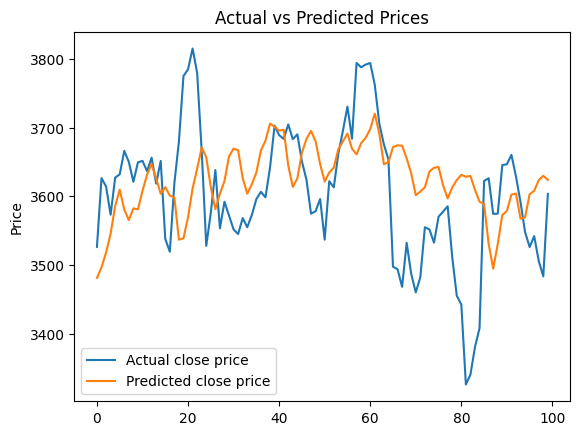

In [95]:
plt.plot(target_scaler.inverse_transform(test_target.reshape(-1,1)), label='Actual close price')
plt.plot(target_scaler.inverse_transform(predictions.reshape(-1,1)), label='Predicted close price')

plt.title('Actual vs Predicted Prices')
plt.ylabel('Price')
plt.legend()

plt.show()

# Appendix

In [122]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [150]:
class PositionalEncoding(Layer):
    def __init__(self, maxlen, dim):
        super(PositionalEncoding, self).__init__()
        self.maxlen = maxlen
        self.dim = dim

    def build(self, input_shape):
        # Create a matrix of shape (maxlen, dim)
        position = np.arange(self.maxlen)[:, np.newaxis]  # Shape (maxlen, 1)
        div_term = np.exp(np.arange(0, self.dim, 2) * -(np.log(10000.0) / self.dim))  # Shape (dim/2,)
        pos_enc = np.zeros((self.maxlen, self.dim))
        pos_enc[:, 0::2] = np.sin(position * div_term)  # Apply sin to even indices
        pos_enc[:, 1::2] = np.cos(position * div_term)  # Apply cos to odd indices
        self.pos_encoding = tf.constant(pos_enc, dtype=tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:inputs.shape[1], :]

In [151]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads, ff_dim, num_layers, dropout):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        self.positional_encoding = self._generate_positional_encoding(embed_dim, 5000)
        
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=ff_dim, dropout=dropout)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        self.fc_out = nn.Linear(embed_dim, 1)

    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        x = self.embedding(x)
        x += self.positional_encoding[:seq_len, :].to(x.device)
        
        x = x.permute(1, 0, 2)  # Transformer expects (seq_len, batch_size, embed_dim)
        x = self.transformer(x)
        x = x.mean(dim=0)  # Pooling over the sequence length
        x = self.fc_out(x)
        return x

    def _generate_positional_encoding(self, embed_dim, max_len):
        pe = torch.zeros(max_len, embed_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * -(np.log(10000.0) / embed_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe.unsqueeze(0)

In [152]:
class TransformerEncoder(Layer):
    def __init__(self, num_heads, key_dim, ff_dim, dropout=0.1, maxlen=500):
        super(TransformerEncoder, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation='relu'),
            Dense(key_dim)
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.positional_encoding = PositionalEncoding(maxlen=maxlen, dim=key_dim)
        #self.dropout1 = Dropout(dropout)
        #self.dropout2 = Dropout(dropout)

    def call(self, inputs, training=False):
        print(f"Input shape before positional encoding: {inputs.shape}")
        # Apply positional encoding
        inputs = self.positional_encoding(inputs)
        print(f"Input shape after positional encoding: {inputs.shape}")
        
        attn_output = self.att(query=inputs, value=inputs, key=inputs)
        #attn_output = self.dropout1(attn_output, training=training)
        print(f"Attention output shape: {attn_output.shape}")
        out1 = self.layernorm1(inputs + attn_output)  # Add & Normalize

        ffn_output = self.ffn(out1)
        #ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # Add & Normalize
        return out2

In [153]:
def create_transformer_model(input_shape, transformer_layers, num_heads, key_dim, ff_dim, dense_units, dropout_rate, maxlen=500):
    # Input Layer
    input_layer = Input(shape=input_shape)

    # Transformer Encoder Layers
    transformer_output = input_layer
    for _ in range(transformer_layers):
        transformer_layer = TransformerEncoder(
            num_heads=num_heads, key_dim=key_dim, ff_dim=ff_dim, dropout=dropout_rate, maxlen=maxlen
        )
        transformer_output = transformer_layer(transformer_output)

    # Global Average Pooling
    pooled_output = GlobalAveragePooling1D()(transformer_output)

    # Dense Layers with Dropout
    dense_1 = Dense(dense_units, activation="relu")(pooled_output)
    #dropout_1 = Dropout(dropout_rate)(dense_1)
    #dense_2 = Dense(dense_units, activation="relu")(dropout_1)
    dense_2 = Dense(dense_units, activation="relu")(dense_1)
    #dropout_2 = Dropout(dropout_rate)(dense_2)

    # Output Layer
    #output_layer = Dense(1, activation="linear")(dropout_2)
    output_layer = Dense(1, activation="linear")(dense_2)

    # Model
    model = Model(inputs=input_layer, outputs=output_layer)
    return model

In [156]:
input_shape = (20, 16)  # Update this based on your dataset
transformer_layers = 3
time2vec_dim = 2
dense_units = 512
dropout_rate = 0.2
num_heads = 4
key_dim = 16
ff_dim = 128

In [157]:
model = create_transformer_model(input_shape, transformer_layers, num_heads, key_dim, ff_dim, dense_units, dropout_rate, 50)

Input shape before positional encoding: (None, 20, 16)
Input shape after positional encoding: (None, 20, 16)
Attention output shape: (None, 20, 16)
Input shape before positional encoding: (None, 20, 16)
Input shape after positional encoding: (None, 20, 16)
Attention output shape: (None, 20, 16)
Input shape before positional encoding: (None, 20, 16)
Input shape after positional encoding: (None, 20, 16)
Attention output shape: (None, 20, 16)
Input shape before positional encoding: (None, 20, 16)
Input shape after positional encoding: (None, 20, 16)
Attention output shape: (None, 20, 16)
Input shape before positional encoding: (None, 20, 16)
Input shape after positional encoding: (None, 20, 16)
Attention output shape: (None, 20, 16)
Input shape before positional encoding: (None, 20, 16)
Input shape after positional encoding: (None, 20, 16)
Attention output shape: (None, 20, 16)


In [158]:
model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 20, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_11          │ (None, 20, 16)         │         8,608 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_12          │ (None, 20, 16)         │         8,608 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_13          │ (None, 20, 16)         │         8,608 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 16)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 512)            │         8,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 297,697 (1.14 MB)

 Trainable params: 297,697 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

In [159]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 20, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_11          │ (None, 20, 16)         │         8,608 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_12          │ (None, 20, 16)         │         8,608 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_13          │ (None, 20, 16)         │         8,608 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 16)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 512)            │         8,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 297,697 (1.14 MB)

 Trainable params: 297,697 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

In [160]:
early_stopping = EarlyStopping(
    monitor='val_loss',          # The metric to monitor (could also be 'val_accuracy')
    patience=10,                 # Number of epochs with no improvement to wait before stopping
    verbose=1,                   # To print messages when stopping early
    restore_best_weights=True    # Restore the best weights once training is stopped
)
#, callbacks=[early_stopping]
history = model.fit(df_train_sequenced,train_target , validation_data=(df_val_sequenced, val_target), epochs=150, batch_size=None)

# Prediction

Epoch 1/150
Input shape before positional encoding: (None, 20, 16)
Input shape after positional encoding: (None, 20, 16)
Attention output shape: (None, 20, 16)
Input shape before positional encoding: (None, 20, 16)
Input shape after positional encoding: (None, 20, 16)
Attention output shape: (None, 20, 16)
Input shape before positional encoding: (None, 20, 16)
Input shape after positional encoding: (None, 20, 16)
Attention output shape: (None, 20, 16)
Input shape before positional encoding: (None, 20, 16)
Input shape after positional encoding: (None, 20, 16)
Attention output shape: (None, 20, 16)
Input shape before positional encoding: (None, 20, 16)
Input shape after positional encoding: (None, 20, 16)
Attention output shape: (None, 20, 16)
Input shape before positional encoding: (None, 20, 16)
Input shape after positional encoding: (None, 20, 16)
Attention output shape: (None, 20, 16)


TypeError: <tf.Tensor 'positional_encoding_10/Const:0' shape=(50, 16) dtype=float32> is out of scope and cannot be used here. Use return values, explicit Python locals or TensorFlow collections to access it.
Please see https://www.tensorflow.org/guide/function#all_outputs_of_a_tffunction_must_be_return_values for more information.

<tf.Tensor 'positional_encoding_10/Const:0' shape=(50, 16) dtype=float32> was defined here:
    File "C:\Users\Divay Nagpal\anaconda3\envs\python310clone\lib\runpy.py", line 196, in _run_module_as_main
    File "C:\Users\Divay Nagpal\anaconda3\envs\python310clone\lib\runpy.py", line 86, in _run_code
    File "C:\Users\Divay Nagpal\anaconda3\envs\python310clone\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    File "C:\Users\Divay Nagpal\anaconda3\envs\python310clone\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    File "C:\Users\Divay Nagpal\anaconda3\envs\python310clone\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
    File "C:\Users\Divay Nagpal\anaconda3\envs\python310clone\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
    File "C:\Users\Divay Nagpal\anaconda3\envs\python310clone\lib\asyncio\base_events.py", line 603, in run_forever
    File "C:\Users\Divay Nagpal\anaconda3\envs\python310clone\lib\asyncio\base_events.py", line 1909, in _run_once
    File "C:\Users\Divay Nagpal\anaconda3\envs\python310clone\lib\asyncio\events.py", line 80, in _run
    File "C:\Users\Divay Nagpal\anaconda3\envs\python310clone\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
    File "C:\Users\Divay Nagpal\anaconda3\envs\python310clone\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one
    File "C:\Users\Divay Nagpal\anaconda3\envs\python310clone\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
    File "C:\Users\Divay Nagpal\anaconda3\envs\python310clone\lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request
    File "C:\Users\Divay Nagpal\anaconda3\envs\python310clone\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
    File "C:\Users\Divay Nagpal\anaconda3\envs\python310clone\lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute
    File "C:\Users\Divay Nagpal\anaconda3\envs\python310clone\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
    File "C:\Users\Divay Nagpal\anaconda3\envs\python310clone\lib\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell
    File "C:\Users\Divay Nagpal\anaconda3\envs\python310clone\lib\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell
    File "C:\Users\Divay Nagpal\anaconda3\envs\python310clone\lib\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner
    File "C:\Users\Divay Nagpal\anaconda3\envs\python310clone\lib\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async
    File "C:\Users\Divay Nagpal\anaconda3\envs\python310clone\lib\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes
    File "C:\Users\Divay Nagpal\anaconda3\envs\python310clone\lib\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code
    File "C:\Users\Divay Nagpal\AppData\Local\Temp\ipykernel_13904\2689084510.py", line 1, in <module>
    File "C:\Users\Divay Nagpal\AppData\Local\Temp\ipykernel_13904\2481964103.py", line 11, in create_transformer_model
    File "C:\Users\Divay Nagpal\anaconda3\envs\python310clone\lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler
    File "C:\Users\Divay Nagpal\anaconda3\envs\python310clone\lib\site-packages\keras\src\layers\layer.py", line 826, in __call__
    File "C:\Users\Divay Nagpal\anaconda3\envs\python310clone\lib\site-packages\keras\src\layers\layer.py", line 1374, in _maybe_build
    File "C:\Users\Divay Nagpal\anaconda3\envs\python310clone\lib\site-packages\keras\src\backend\tensorflow\core.py", line 212, in compute_output_spec
    File "C:\Users\Divay Nagpal\AppData\Local\Temp\ipykernel_13904\2823449933.py", line 18, in call
    File "C:\Users\Divay Nagpal\anaconda3\envs\python310clone\lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler
    File "C:\Users\Divay Nagpal\anaconda3\envs\python310clone\lib\site-packages\keras\src\layers\layer.py", line 826, in __call__
    File "C:\Users\Divay Nagpal\anaconda3\envs\python310clone\lib\site-packages\keras\src\layers\layer.py", line 1365, in _maybe_build
    File "C:\Users\Divay Nagpal\anaconda3\envs\python310clone\lib\site-packages\keras\src\layers\layer.py", line 226, in build_wrapper
    File "C:\Users\Divay Nagpal\AppData\Local\Temp\ipykernel_13904\1160251778.py", line 14, in build
    File "C:\Users\Divay Nagpal\anaconda3\envs\python310clone\lib\site-packages\tensorflow\python\ops\weak_tensor_ops.py", line 142, in wrapper
    File "C:\Users\Divay Nagpal\anaconda3\envs\python310clone\lib\site-packages\tensorflow\python\framework\constant_op.py", line 276, in constant
    File "C:\Users\Divay Nagpal\anaconda3\envs\python310clone\lib\site-packages\tensorflow\python\framework\constant_op.py", line 291, in _constant_impl
    File "C:\Users\Divay Nagpal\anaconda3\envs\python310clone\lib\site-packages\tensorflow\python\framework\ops.py", line 289, in _create_graph_constant
    File "C:\Users\Divay Nagpal\anaconda3\envs\python310clone\lib\site-packages\tensorflow\python\framework\func_graph.py", line 670, in _create_op_internal
    File "C:\Users\Divay Nagpal\anaconda3\envs\python310clone\lib\site-packages\tensorflow\python\framework\ops.py", line 2701, in _create_op_internal
    File "C:\Users\Divay Nagpal\anaconda3\envs\python310clone\lib\site-packages\tensorflow\python\framework\ops.py", line 1196, in from_node_def

The tensor <tf.Tensor 'positional_encoding_10/Const:0' shape=(50, 16) dtype=float32> cannot be accessed from here, because it was defined in FuncGraph(name=scratch_graph_20, id=2358024992960), which is out of scope.

In [145]:
df_train_sequenced.shape

(949, 20, 16)

In [83]:
class StockPriceDataset(Dataset):
    def __init__(self, data, sequence_length):
        self.data = data
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.data) - self.sequence_length

    def __getitem__(self, idx):
        seq = self.data[idx:idx + self.sequence_length, :-1]  # Exclude target ('Scaled_Close')
        target = self.data[idx + self.sequence_length, -1]  # 'Scaled_Close' as target
        return torch.tensor(seq, dtype=torch.float32), torch.tensor(target, dtype=torch.float32)


In [84]:
sequence_length = 20
input_dim = 11  # All features except 'Scaled_Close'
embed_dim = 64
num_heads = 4
ff_dim = 128
num_layers = 3
dropout = 0.1
lr = 0.001
num_epochs = 50
batch_size = 32

In [85]:
train_dataset = StockPriceDataset(df_train, sequence_length)
val_dataset = StockPriceDataset(df_val, sequence_length)
test_dataset = StockPriceDataset(df_test, sequence_length)

In [97]:
train_loader = DataLoader(train_dataset, batch_size=None, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=None, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=None, shuffle=False)

In [91]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads, ff_dim, num_layers, dropout):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        self.positional_encoding = self._generate_positional_encoding(embed_dim, 5000)
        
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=ff_dim, dropout=dropout)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        self.fc_out = nn.Linear(embed_dim, 1)

    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        x = self.embedding(x)
        x += self.positional_encoding[:seq_len, :].to(x.device)
        
        x = x.permute(1, 0, 2)  # Transformer expects (seq_len, batch_size, embed_dim)
        x = self.transformer(x)
        x = x.mean(dim=0)  # Pooling over the sequence length
        x = self.fc_out(x)
        return x

    def _generate_positional_encoding(self, embed_dim, max_len):
        pe = torch.zeros(max_len, embed_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * -(np.log(10000.0) / embed_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe.unsqueeze(0)

In [92]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TransformerModel(input_dim, embed_dim, num_heads, ff_dim, num_layers, dropout).to(device)


C:\Users\Divay Nagpal\anaconda3\envs\python310clone\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [93]:
# Training Configuration
def train_model(model, train_loader, val_loader, num_epochs, lr):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    best_val_loss = float('inf')
    early_stopping_counter = 0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        for seq, target in train_loader:
            seq, target = seq.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(seq)
            loss = criterion(output.squeeze(), target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for seq, target in val_loader:
                seq, target = seq.to(device), target.to(device)
                output = model(seq)
                loss = criterion(output.squeeze(), target)
                val_loss += loss.item()

        val_loss /= len(val_loader)

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stopping_counter = 0
            best_model_state = model.state_dict()
        else:
            early_stopping_counter += 1

        if early_stopping_counter >= 5:  # Stop training if no improvement for 5 consecutive epochs
            print("Early stopping triggered.")
            break

    model.load_state_dict(best_model_state)

In [96]:
train_model(model, train_loader, val_loader, num_epochs, lr)

InvalidIndexError: (slice(202, 222, None), slice(None, -1, None))

df_train.drop(columns=["Date"], inplace = True)
df_val.drop(columns=["Date"], inplace = True)
df_test.drop(columns=["Date"], inplace = True)

In [47]:
df_train

NameError: name 'df_train' is not defined

In [41]:
class StockPriceDataset(Dataset):
    def __init__(self, data, sequence_length):
        self.data = data
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.data) - self.sequence_length

    def __getitem__(self, idx):
        seq = self.data[idx:idx + self.sequence_length, :-1]  # Exclude target ('Scaled_Close')
        target = self.data[idx + self.sequence_length, -1]  # 'Scaled_Close' as target
        return torch.tensor(seq, dtype=torch.float32), torch.tensor(target, dtype=torch.float32)

In [40]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads, ff_dim, num_layers, dropout):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        self.positional_encoding = self._generate_positional_encoding(embed_dim, 5000)
        
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=ff_dim, dropout=dropout)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        self.fc_out = nn.Linear(embed_dim, 1)

    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        x = self.embedding(x)
        x += self.positional_encoding[:seq_len, :].to(x.device)
        
        x = x.permute(1, 0, 2)  # Transformer expects (seq_len, batch_size, embed_dim)
        x = self.transformer(x)
        x = x.mean(dim=0)  # Pooling over the sequence length
        x = self.fc_out(x)
        return x

    def _generate_positional_encoding(self, embed_dim, max_len):
        pe = torch.zeros(max_len, embed_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * -(np.log(10000.0) / embed_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe.unsqueeze(0)

In [42]:
def train_model(model, dataloader, num_epochs, lr):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for seq, target in dataloader:
            seq, target = seq.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(seq)
            loss = criterion(output.squeeze(), target)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss / len(dataloader):.4f}")


In [44]:
sequence_length = 20
input_dim = 11  # All features except 'Scaled_Close'
embed_dim = 64
num_heads = 4
ff_dim = 128
num_layers = 3
dropout = 0.1
lr = 0.001
num_epochs = 50
batch_size = 32

In [46]:
dataset = StockPriceDataset(df_train, sequence_length)

NameError: name 'df_train' is not defined

def make_stationary(df, columns):
    for col in columns:
        df[col] = df[col].diff()
    df.dropna(inplace=True)
    return df

df_train

stationary_columns = ['Adj_Close', 'Close', 'High', 'Low', 'Open', 'Volume', '10DaysMA', '30DaysMA', '50DaysMA']
df_train_scaled = make_stationary(df_train, stationary_columns)
df_val_scaled = make_stationary(df_val, stationary_columns)
df_test_scaled = make_stationary(df_test, stationary_columns)

def create_sequences(data, timesteps, features):
    sequences = []
    targets = []
    for i in range(len(data) - timesteps):
        seq = data.iloc[i:i + timesteps, :features].values
        target = data.iloc[i + timesteps]['Scaled_Next_Close']
        sequences.append(seq) 
        targets.append(target)
    return np.array(sequences), np.array(targets)

In [84]:
timesteps = 10
features = 12

train_sequences, train_targets = create_sequences(df_train_scaled, timesteps, features)
val_sequences, val_targets = create_sequences(df_val_scaled, timesteps, features)
test_sequences, test_targets = create_sequences(df_test_scaled, timesteps, features)

print(f"Train sequences shape: {train_sequences.shape}")
print(f"Validation sequences shape: {val_sequences.shape}")
print(f"Test sequences shape: {test_sequences.shape}")

In [394]:
class EnhancedTime2Vec(nn.Module):
    def __init__(self, input_dim, output_dim):
        """
        Time2Vec layer that includes both sine and cosine periodicity along with a linear term.
        
        Args:
        - input_dim (int): Number of input features (time steps).
        - output_dim (int): Number of output dimensions for encoding.
        """
        super(EnhancedTime2Vec, self).__init__()
        self.linear = nn.Linear(input_dim, 1, bias=True)  # Linear term
        self.sin_periodic = nn.Linear(input_dim, (output_dim - 1) // 2, bias=True)  # Sine terms
        self.cos_periodic = nn.Linear(input_dim, (output_dim - 1) // 2, bias=True)  # Cosine terms

    def forward(self, x):
        """
        Forward pass to calculate Time2Vec encoding.

        Args:
        - x (Tensor): Input tensor of shape (Batch Size, Input Dim).

        Returns:
        - Tensor: Output tensor of shape (Batch Size, Output Dim).
        """
        linear_part = self.linear(x)  # Linear component
        sin_part = torch.sin(self.sin_periodic(x))  # Sine periodicity
        cos_part = torch.cos(self.cos_periodic(x))  # Cosine periodicity
        return torch.cat([linear_part, sin_part, cos_part], dim=-1)

In [395]:
class Time2Vec(Layer):
    def __init__(self, kernel_size=1, **kwargs):
        super(Time2Vec, self).__init__(**kwargs)
        self.kernel_size = kernel_size

    def build(self, input_shape):
        # Linear and periodic components
        self.w0 = self.add_weight(shape=(1,), initializer='uniform', trainable=True, name='w0')
        self.b0 = self.add_weight(shape=(1,), initializer='uniform', trainable=True, name='b0')
        self.w = self.add_weight(shape=(self.kernel_size, 1), initializer='uniform', trainable=True, name='w')
        self.b = self.add_weight(shape=(self.kernel_size, 1), initializer='uniform', trainable=True, name='b')

    def call(self, inputs):
        # First component is linear
        v1 = self.w0 * inputs + self.b0
        # Additional components are periodic
        v2 = tf.math.sin(tf.matmul(inputs, self.w) + self.b)
        return tf.concat([v1, v2], axis=-1)

In [ ]:
############## New test code

In [83]:
class Time2Vec(Layer):
    def __init__(self, kernel_size=1, **kwargs):
        super(Time2Vec, self).__init__(**kwargs)
        self.kernel_size = kernel_size

    def build(self, input_shape):
        self.w0 = self.add_weight(shape=(1,), initializer='uniform', trainable=True, name='w0')
        self.b0 = self.add_weight(shape=(1,), initializer='uniform', trainable=True, name='b0')
        self.w = self.add_weight(shape=(self.kernel_size, 1), initializer='uniform', trainable=True, name='w')
        self.b = self.add_weight(shape=(self.kernel_size, 1), initializer='uniform', trainable=True, name='b')

    def call(self, inputs):
        linear_term = self.w0 * inputs + self.b0
        periodic_term = tf.math.sin(tf.matmul(inputs, self.w) + self.b)
        return tf.concat([linear_term, periodic_term], axis=-1)

In [97]:
df_train.iloc[0:10,[0,1,2,3,4,5,7,8,9,10]].values

array([[1.61603962e-01, 1.73237691e-01, 1.94579784e-01, 1.87701858e-01,
        2.65253635e-01, 1.58068800e+09, 1.64217560e-01, 1.49831299e-01,
        1.46719942e-01, 1.81469004e-01],
       [1.63052828e-01, 1.74312237e-01, 1.99531871e-01, 1.89601675e-01,
        1.61959118e-01, 1.58077440e+09, 1.63897876e-01, 1.49626756e-01,
        1.46153318e-01, 1.83068119e-01],
       [1.68251848e-01, 1.79906141e-01, 2.01904392e-01, 1.90203291e-01,
        1.91365938e-01, 1.58086080e+09, 1.64375903e-01, 1.49721688e-01,
        1.45816589e-01, 1.88806161e-01],
       [1.70396699e-01, 1.79906141e-01, 2.06378787e-01, 1.98119193e-01,
        1.02273436e-01, 1.58094720e+09, 1.63932563e-01, 1.50123432e-01,
        1.45702754e-01, 1.91173465e-01],
       [1.65112543e-01, 1.76556118e-01, 2.02222853e-01, 1.95000335e-01,
        1.35670171e-01, 1.58103360e+09, 1.62116997e-01, 1.50117138e-01,
        1.45379059e-01, 1.85341381e-01],
       [1.61220395e-01, 1.72779409e-01, 1.94930084e-01, 1.90868219e-01,
   

In [98]:
def create_sequences_with_time2vec(data, timesteps, features, time2vec):
    sequences = []
    targets = []

    for i in range(len(data) - timesteps):
        # Extract sequence features and target
        seq = data.iloc[i:i + timesteps, features].values
        epoch_times = data.iloc[i:i + timesteps]['epoch_time'].values.reshape(-1, 1)  # Shape (timesteps, 1)

        # Apply Time2Vec on epoch times
        time2vec_features = time2vec(tf.convert_to_tensor(epoch_times, dtype=tf.float32)).numpy()
        # Concatenate Time2Vec features with other sequence features
        enhanced_seq = np.concatenate([seq, time2vec_features], axis=-1)

        # Append enhanced sequence and target
        sequences.append(enhanced_seq)
        targets.append(data.iloc[i + timesteps]['Scaled_Close'])

    return np.array(sequences), np.array(targets)

In [99]:
timesteps = 50
features = [0,1,2,3,4,5,7,8,9,10]# Excluding 'epoch_time' and 'Next_Close'
time2vec_layer = Time2Vec(kernel_size=1)  # Example kernel size

In [100]:
df_test.columns
df_train_scaled=df_train.copy()
df_val_scaled=df_val.copy()
df_test_scaled=df_test.copy()

In [101]:
sequences, targets = create_sequences_with_time2vec(df_train_scaled, timesteps, features, time2vec_layer)
sequences_val, targets_val = create_sequences_with_time2vec(df_val_scaled, timesteps, features, time2vec_layer)
sequences_test, targets_test = create_sequences_with_time2vec(df_test_scaled, timesteps, features, time2vec_layer)

In [102]:
print("Sequence shape:", sequences.shape)  # Expected: (num_sequences, timesteps, original_features + Time2Vec features)
print("Targets shape:", targets.shape) 
print("Sequence val shape:", sequences_val.shape)  # Expected: (num_sequences, timesteps, original_features + Time2Vec features)
print("Targets val shape:", targets_val.shape) 

Sequence shape: (919, 50, 12)
Targets shape: (919,)
Sequence val shape: (51, 50, 12)
Targets val shape: (51,)


In [104]:
df_train_scaled

,Adj_Close,High,Low,Open,Volume,epoch_time,opt_expiry,10DaysMA,30DaysMA,50DaysMA,Scaled_Close
49,0.161604,0.173238,0.194580,0.187702,0.265254,1.580688e+09,0,0.164218,0.149831,0.146720,0.181469
50,0.163053,0.174312,0.199532,0.189602,0.161959,1.580774e+09,0,0.163898,0.149627,0.146153,0.183068
51,0.168252,0.179906,0.201904,0.190203,0.191366,1.580861e+09,0,0.164376,0.149722,0.145817,0.188806
52,0.170397,0.179906,0.206379,0.198119,0.102273,1.580947e+09,0,0.163933,0.150123,0.145703,0.191173
53,0.165113,0.176556,0.202223,0.195000,0.135670,1.581034e+09,0,0.162117,0.150117,0.145379,0.185341
...,...,...,...,...,...,...,...,...,...,...,...
1013,0.870499,0.866030,0.875004,0.863403,0.070147,1.703203e+09,0,0.887673,0.842975,0.812802,0.868558
1014,0.874237,0.869934,0.897089,0.880486,0.041043,1.703549e+09,0,0.891092,0.848281,0.815577,0.872352
1015,0.890903,0.882781,0.905433,0.890634,0.056181,1.703635e+09,0,0.897703,0.854107,0.818774,0.889269
1016,0.882886,0.886241,0.904271,0.901716,0.150823,1.703722e+09,1,0.901581,0.859462,0.821737,0.881132


In [107]:
sequences.shape

(919, 50, 12)

In [106]:
class TransformerEncoder(Layer):
    def __init__(self, num_heads, key_dim, ff_dim, dropout=0.1):
        super(TransformerEncoder, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation='relu'),
            Dense(key_dim)
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        #self.dropout1 = Dropout(dropout)
        #self.dropout2 = Dropout(dropout)

    def call(self, inputs, training=False):
        print(f"Input shape before attention: {inputs.shape}")
        attn_output = self.att(query=inputs, value=inputs, key=inputs)
        #attn_output = self.dropout1(attn_output, training=training)
        print(f"Attention output shape: {attn_output.shape}")
        out1 = self.layernorm1(inputs + attn_output)  # Add & Normalize

        ffn_output = self.ffn(out1)
        #ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # Add & Normalize
        return out2

In [114]:
def create_transformer_model(input_shape, transformer_layers, num_heads, key_dim, ff_dim, dense_units, dropout_rate):
    # Input Layer
    input_layer = Input(shape=input_shape)

    # Transformer Encoder Layers
    transformer_output = input_layer
    for _ in range(transformer_layers):
        transformer_layer = TransformerEncoder(
            num_heads=num_heads, key_dim=key_dim, ff_dim=ff_dim, dropout=dropout_rate
        )
        transformer_output = transformer_layer(transformer_output)

    # Global Average Pooling
    pooled_output = GlobalAveragePooling1D()(transformer_output)

    # Dense Layers with Dropout
    dense_1 = Dense(dense_units, activation="relu")(pooled_output)
    #dropout_1 = Dropout(dropout_rate)(dense_1)
    #dense_2 = Dense(dense_units, activation="relu")(dropout_1)
    dense_2 = Dense(dense_units, activation="relu")(dense_1)
    #dropout_2 = Dropout(dropout_rate)(dense_2)

    # Output Layer
    #output_layer = Dense(1, activation="linear")(dropout_2)
    output_layer = Dense(1, activation="linear")(dense_2)

    # Model
    model = Model(inputs=input_layer, outputs=output_layer)
    return model

In [115]:
input_shape = (50, 12)  # Update this based on your dataset
transformer_layers = 3
time2vec_dim = 2
dense_units = 512
dropout_rate = 0.2
num_heads = 4
key_dim = 12
ff_dim = 128

In [116]:
model = create_transformer_model(input_shape, transformer_layers, num_heads, key_dim, ff_dim, dense_units, dropout_rate)

Input shape before attention: (None, 50, 12)
Attention output shape: (None, 50, 12)
Input shape before attention: (None, 50, 12)
Attention output shape: (None, 50, 12)
Input shape before attention: (None, 50, 12)
Attention output shape: (None, 50, 12)
Input shape before attention: (None, 50, 12)
Attention output shape: (None, 50, 12)
Input shape before attention: (None, 50, 12)
Attention output shape: (None, 50, 12)
Input shape before attention: (None, 50, 12)
Attention output shape: (None, 50, 12)


In [117]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 50, 12)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_3           │ (None, 50, 12)         │         5,720 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_4           │ (None, 50, 12)         │         5,720 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_5           │ (None, 50, 12)         │         5,720 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 12)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 512)            │         6,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 286,985 (1.09 MB)

 Trainable params: 286,985 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

In [121]:
early_stopping = EarlyStopping(
    monitor='val_loss',          # The metric to monitor (could also be 'val_accuracy')
    patience=10,                 # Number of epochs with no improvement to wait before stopping
    verbose=1,                   # To print messages when stopping early
    restore_best_weights=True    # Restore the best weights once training is stopped
)
#, callbacks=[early_stopping]
history = model.fit(sequences,targets , validation_data=(sequences_val, targets_val), epochs=150, batch_size=None)

# Prediction


Epoch 1/150
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0423 - mae: 0.1624 - val_loss: 0.4294 - val_mae: 0.6539
Epoch 2/150
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0417 - mae: 0.1585 - val_loss: 0.3155 - val_mae: 0.5600
Epoch 3/150
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0400 - mae: 0.1592 - val_loss: 0.4138 - val_mae: 0.6418
Epoch 4/150
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0375 - mae: 0.1508 - val_loss: 0.3084 - val_mae: 0.5537
Epoch 5/150
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0376 - mae: 0.1508 - val_loss: 0.3778 - val_mae: 0.6132
Epoch 6/150
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0357 - mae: 0.1441 - val_loss: 0.2882 - val_mae: 0.5351
Epoch 7/150
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0375 - mae: 0.1538 - val_loss: 0.3437 - val_mae: 0.5847
Epoch 8/150
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0404 - mae: 0.1559 - val_loss: 0.3703 - val_mae: 0.6071
Epoch 9/150
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - lo

KeyboardInterrupt: 

In [119]:
predictions = model.predict(sequences_test)

Input shape before attention: (32, 50, 12)
Attention output shape: (32, 50, 12)
Input shape before attention: (32, 50, 12)
Attention output shape: (32, 50, 12)
Input shape before attention: (32, 50, 12)
Attention output shape: (32, 50, 12)
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/stepInput shape before attention: (None, 50, 12)
Attention output shape: (None, 50, 12)
Input shape before attention: (None, 50, 12)
Attention output shape: (None, 50, 12)
Input shape before attention: (None, 50, 12)
Attention output shape: (None, 50, 12)
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


In [120]:
target_scaler.inverse_transform(predictions.reshape(-1,1))

array([[2157.7493],
       [2157.7498],
       [2157.7493],
       [2157.7495],
       [2157.7505],
       [2157.7495],
       [2157.7505],
       [2157.7495],
       [2157.7485],
       [2157.7498],
       [2157.7488],
       [2157.7505],
       [2157.7498],
       [2157.7488],
       [2157.7498],
       [2157.7505],
       [2157.7498],
       [2157.749 ],
       [2157.748 ],
       [2157.7495],
       [2157.75  ],
       [2157.7495],
       [2157.7488],
       [2157.7478],
       [2157.7488],
       [2157.7498],
       [2157.7488],
       [2157.7483],
       [2157.7473],
       [2157.748 ],
       [2157.749 ],
       [2157.7485],
       [2157.7483],
       [2157.7478],
       [2157.7505],
       [2157.7498],
       [2157.7498],
       [2157.749 ],
       [2157.7502],
       [2157.751 ],
       [2157.7502],
       [2157.7493],
       [2157.7485],
       [2157.7498],
       [2157.7505],
       [2157.7498],
       [2157.749 ],
       [2157.748 ],
       [2157.749 ],
       [2157.75  ],


In [319]:
model = create_transformer_model(sequences,input_shape, time2vec_dim, transformer_layers, dense_units, dropout_rate)
# Compile the Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="mse", metrics=["mae"])

# Summary
model.summary()

Input shape before attention: (958, 10, 12)
Attention output shape: (958, 10, 12)
Input shape before attention: (958, 10, 12)
Attention output shape: (958, 10, 12)
Input shape before attention: (958, 10, 12)
Attention output shape: (958, 10, 12)
Input shape before attention: (958, 10, 12)
Attention output shape: (958, 10, 12)
Input shape before attention: (958, 10, 12)
Attention output shape: (958, 10, 12)
Input shape before attention: (958, 10, 12)
Attention output shape: (958, 10, 12)


NameError: name 'input_layer' is not defined

In [265]:
input_columns = ['Adj_Close', 'Close', 'High', 'Low', 'Open', 'Volume', 
                 'opt_expiry', '10DaysMA', '30DaysMA', '50DaysMA']
time_column = 'epoch_time'
target_column = 'Next_Close'

In [267]:
epoch_times = df_train_scaled[time_column].values.reshape(-1, 1)  # Reshape epoch_time to (num_samples, 1)
features = df_train_scaled[input_columns].values  # Other input features
targets = df_train_scaled[target_column].values.reshape(-1, 1)  # Target variable

In [274]:
time_input = Input(shape=(1,), name="epoch_time")
other_inputs = Input(shape=(len(input_columns),), name="other_features")

In [275]:
time2vec = Time2Vec(kernel_size=1)(time_input)

In [276]:
concat_inputs = Concatenate()([time2vec, other_inputs])

In [278]:
# Transformer-like Dense Layers
dense1 = Dense(64, activation='relu')(concat_inputs)
dense2 = Dense(32, activation='relu')(dense1)
# Output layer
output = Dense(1, name='Next_Close')(dense2)

In [279]:
model = tf.keras.Model(inputs=[time_input, other_inputs], outputs=output)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [280]:
model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ epoch_time          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time2_vec_19        │ (None, 2)         │          4 │ epoch_time[0][0]  │
│ (Time2Vec)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ other_features      │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_17      │ (None, 12)        │          0 │ time2_vec_19[0][… │
│ (Concatenate)       │                   │            │ other_features[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_38 (Dense)    │ (None, 64)        │        832 │ concatenate_17[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_39 (Dense)    │ (None, 32)        │      2,080 │ dense_38[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Next_Close (Dense)  │ (None, 1)         │         33 │ dense_39[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,949 (11.52 KB)

 Trainable params: 2,949 (11.52 KB)

 Non-trainable params: 0 (0.00 B)

In [304]:
history = model.fit(
    {'epoch_time': epoch_times, 'other_features': features}, 
    targets, 
    epochs=100, 
    batch_size=None
)

ValueError: Unrecognized data type: x={'epoch_time': array([[1.5807744e+09],
       [1.5808608e+09],
       [1.5809472e+09],
       [1.5810336e+09],
       [1.5812928e+09],
       [1.5813792e+09],
       [1.5814656e+09],
       [1.5815520e+09],
       [1.5816384e+09],
       [1.5818976e+09],
       [1.5819840e+09],
       [1.5820704e+09],
       [1.5821568e+09],
       [1.5825024e+09],
       [1.5825888e+09],
       [1.5826752e+09],
       [1.5827616e+09],
       [1.5828480e+09],
       [1.5831072e+09],
       [1.5831936e+09],
       [1.5832800e+09],
       [1.5833664e+09],
       [1.5834528e+09],
       [1.5837120e+09],
       [1.5838848e+09],
       [1.5839712e+09],
       [1.5840576e+09],
       [1.5843168e+09],
       [1.5844032e+09],
       [1.5844896e+09],
       [1.5845760e+09],
       [1.5846624e+09],
       [1.5849216e+09],
       [1.5850080e+09],
       [1.5850944e+09],
       [1.5851808e+09],
       [1.5852672e+09],
       [1.5855264e+09],
       [1.5856128e+09],
       [1.5856992e+09],
       [1.5858720e+09],
       [1.5862176e+09],
       [1.5863040e+09],
       [1.5863904e+09],
       [1.5867360e+09],
       [1.5869088e+09],
       [1.5869952e+09],
       [1.5870816e+09],
       [1.5873408e+09],
       [1.5874272e+09],
       [1.5875136e+09],
       [1.5876000e+09],
       [1.5876864e+09],
       [1.5879456e+09],
       [1.5880320e+09],
       [1.5881184e+09],
       [1.5882048e+09],
       [1.5885504e+09],
       [1.5886368e+09],
       [1.5887232e+09],
       [1.5888096e+09],
       [1.5888960e+09],
       [1.5891552e+09],
       [1.5892416e+09],
       [1.5893280e+09],
       [1.5894144e+09],
       [1.5895008e+09],
       [1.5897600e+09],
       [1.5898464e+09],
       [1.5899328e+09],
       [1.5900192e+09],
       [1.5901056e+09],
       [1.5904512e+09],
       [1.5905376e+09],
       [1.5906240e+09],
       [1.5907104e+09],
       [1.5909696e+09],
       [1.5910560e+09],
       [1.5911424e+09],
       [1.5912288e+09],
       [1.5913152e+09],
       [1.5915744e+09],
       [1.5916608e+09],
       [1.5917472e+09],
       [1.5918336e+09],
       [1.5919200e+09],
       [1.5921792e+09],
       [1.5922656e+09],
       [1.5923520e+09],
       [1.5924384e+09],
       [1.5925248e+09],
       [1.5927840e+09],
       [1.5928704e+09],
       [1.5929568e+09],
       [1.5930432e+09],
       [1.5931296e+09],
       [1.5933888e+09],
       [1.5934752e+09],
       [1.5935616e+09],
       [1.5936480e+09],
       [1.5937344e+09],
       [1.5939936e+09],
       [1.5940800e+09],
       [1.5941664e+09],
       [1.5942528e+09],
       [1.5943392e+09],
       [1.5945984e+09],
       [1.5946848e+09],
       [1.5947712e+09],
       [1.5948576e+09],
       [1.5949440e+09],
       [1.5952032e+09],
       [1.5952896e+09],
       [1.5953760e+09],
       [1.5954624e+09],
       [1.5955488e+09],
       [1.5958080e+09],
       [1.5958944e+09],
       [1.5959808e+09],
       [1.5960672e+09],
       [1.5961536e+09],
       [1.5964128e+09],
       [1.5964992e+09],
       [1.5965856e+09],
       [1.5966720e+09],
       [1.5967584e+09],
       [1.5970176e+09],
       [1.5971040e+09],
       [1.5971904e+09],
       [1.5972768e+09],
       [1.5973632e+09],
       [1.5976224e+09],
       [1.5977088e+09],
       [1.5977952e+09],
       [1.5978816e+09],
       [1.5979680e+09],
       [1.5982272e+09],
       [1.5983136e+09],
       [1.5984000e+09],
       [1.5984864e+09],
       [1.5985728e+09],
       [1.5988320e+09],
       [1.5989184e+09],
       [1.5990048e+09],
       [1.5990912e+09],
       [1.5991776e+09],
       [1.5994368e+09],
       [1.5995232e+09],
       [1.5996096e+09],
       [1.5996960e+09],
       [1.5997824e+09],
       [1.6000416e+09],
       [1.6001280e+09],
       [1.6002144e+09],
       [1.6003008e+09],
       [1.6003872e+09],
       [1.6006464e+09],
       [1.6007328e+09],
       [1.6008192e+09],
       [1.6009056e+09],
       [1.6009920e+09],
       [1.6012512e+09],
       [1.6013376e+09],
       [1.6014240e+09],
       [1.6015104e+09],
       [1.6018560e+09],
       [1.6019424e+09],
       [1.6020288e+09],
       [1.6021152e+09],
       [1.6022016e+09],
       [1.6024608e+09],
       [1.6025472e+09],
       [1.6026336e+09],
       [1.6027200e+09],
       [1.6028064e+09],
       [1.6030656e+09],
       [1.6031520e+09],
       [1.6032384e+09],
       [1.6033248e+09],
       [1.6034112e+09],
       [1.6036704e+09],
       [1.6037568e+09],
       [1.6038432e+09],
       [1.6039296e+09],
       [1.6040160e+09],
       [1.6042752e+09],
       [1.6043616e+09],
       [1.6044480e+09],
       [1.6045344e+09],
       [1.6046208e+09],
       [1.6048800e+09],
       [1.6049664e+09],
       [1.6050528e+09],
       [1.6051392e+09],
       [1.6052256e+09],
       [1.6053120e+09],
       [1.6055712e+09],
       [1.6056576e+09],
       [1.6057440e+09],
       [1.6058304e+09],
       [1.6060896e+09],
       [1.6061760e+09],
       [1.6062624e+09],
       [1.6063488e+09],
       [1.6064352e+09],
       [1.6067808e+09],
       [1.6068672e+09],
       [1.6069536e+09],
       [1.6070400e+09],
       [1.6072992e+09],
       [1.6073856e+09],
       [1.6074720e+09],
       [1.6075584e+09],
       [1.6076448e+09],
       [1.6079040e+09],
       [1.6079904e+09],
       [1.6080768e+09],
       [1.6081632e+09],
       [1.6082496e+09],
       [1.6085088e+09],
       [1.6085952e+09],
       [1.6086816e+09],
       [1.6087680e+09],
       [1.6091136e+09],
       [1.6092000e+09],
       [1.6092864e+09],
       [1.6093728e+09],
       [1.6094592e+09],
       [1.6097184e+09],
       [1.6098048e+09],
       [1.6098912e+09],
       [1.6099776e+09],
       [1.6100640e+09],
       [1.6103232e+09],
       [1.6104096e+09],
       [1.6104960e+09],
       [1.6105824e+09],
       [1.6106688e+09],
       [1.6109280e+09],
       [1.6110144e+09],
       [1.6111008e+09],
       [1.6111872e+09],
       [1.6112736e+09],
       [1.6115328e+09],
       [1.6117056e+09],
       [1.6117920e+09],
       [1.6118784e+09],
       [1.6121376e+09],
       [1.6122240e+09],
       [1.6123104e+09],
       [1.6123968e+09],
       [1.6124832e+09],
       [1.6127424e+09],
       [1.6128288e+09],
       [1.6129152e+09],
       [1.6130016e+09],
       [1.6130880e+09],
       [1.6133472e+09],
       [1.6134336e+09],
       [1.6135200e+09],
       [1.6136064e+09],
       [1.6136928e+09],
       [1.6139520e+09],
       [1.6140384e+09],
       [1.6141248e+09],
       [1.6142112e+09],
       [1.6142976e+09],
       [1.6145568e+09],
       [1.6146432e+09],
       [1.6147296e+09],
       [1.6148160e+09],
       [1.6149024e+09],
       [1.6151616e+09],
       [1.6152480e+09],
       [1.6153344e+09],
       [1.6155072e+09],
       [1.6157664e+09],
       [1.6158528e+09],
       [1.6159392e+09],
       [1.6160256e+09],
       [1.6161120e+09],
       [1.6163712e+09],
       [1.6164576e+09],
       [1.6165440e+09],
       [1.6166304e+09],
       [1.6167168e+09],
       [1.6170624e+09],
       [1.6171488e+09],
       [1.6172352e+09],
       [1.6175808e+09],
       [1.6176672e+09],
       [1.6177536e+09],
       [1.6178400e+09],
       [1.6179264e+09],
       [1.6181856e+09],
       [1.6182720e+09],
       [1.6184448e+09],
       [1.6185312e+09],
       [1.6187904e+09],
       [1.6188768e+09],
       [1.6190496e+09],
       [1.6191360e+09],
       [1.6193952e+09],
       [1.6194816e+09],
       [1.6195680e+09],
       [1.6196544e+09],
       [1.6197408e+09],
       [1.6200000e+09],
       [1.6200864e+09],
       [1.6201728e+09],
       [1.6202592e+09],
       [1.6203456e+09],
       [1.6206048e+09],
       [1.6206912e+09],
       [1.6207776e+09],
       [1.6209504e+09],
       [1.6212096e+09],
       [1.6212960e+09],
       [1.6213824e+09],
       [1.6214688e+09],
       [1.6215552e+09],
       [1.6218144e+09],
       [1.6219008e+09],
       [1.6219872e+09],
       [1.6220736e+09],
       [1.6221600e+09],
       [1.6224192e+09],
       [1.6225056e+09],
       [1.6225920e+09],
       [1.6226784e+09],
       [1.6227648e+09],
       [1.6230240e+09],
       [1.6231104e+09],
       [1.6231968e+09],
       [1.6232832e+09],
       [1.6233696e+09],
       [1.6236288e+09],
       [1.6237152e+09],
       [1.6238016e+09],
       [1.6238880e+09],
       [1.6239744e+09],
       [1.6242336e+09],
       [1.6243200e+09],
       [1.6244064e+09],
       [1.6244928e+09],
       [1.6245792e+09],
       [1.6248384e+09],
       [1.6249248e+09],
       [1.6250112e+09],
       [1.6250976e+09],
       [1.6251840e+09],
       [1.6254432e+09],
       [1.6255296e+09],
       [1.6256160e+09],
       [1.6257024e+09],
       [1.6257888e+09],
       [1.6260480e+09],
       [1.6261344e+09],
       [1.6262208e+09],
       [1.6263072e+09],
       [1.6263936e+09],
       [1.6266528e+09],
       [1.6267392e+09],
       [1.6269120e+09],
       [1.6269984e+09],
       [1.6272576e+09],
       [1.6273440e+09],
       [1.6274304e+09],
       [1.6275168e+09],
       [1.6276032e+09],
       [1.6278624e+09],
       [1.6279488e+09],
       [1.6280352e+09],
       [1.6281216e+09],
       [1.6282080e+09],
       [1.6284672e+09],
       [1.6285536e+09],
       [1.6286400e+09],
       [1.6287264e+09],
       [1.6288128e+09],
       [1.6290720e+09],
       [1.6291584e+09],
       [1.6292448e+09],
       [1.6294176e+09],
       [1.6296768e+09],
       [1.6297632e+09],
       [1.6298496e+09],
       [1.6299360e+09],
       [1.6300224e+09],
       [1.6302816e+09],
       [1.6303680e+09],
       [1.6304544e+09],
       [1.6305408e+09],
       [1.6306272e+09],
       [1.6308864e+09],
       [1.6309728e+09],
       [1.6310592e+09],
       [1.6311456e+09],
       [1.6314912e+09],
       [1.6315776e+09],
       [1.6316640e+09],
       [1.6317504e+09],
       [1.6318368e+09],
       [1.6320960e+09],
       [1.6321824e+09],
       [1.6322688e+09],
       [1.6323552e+09],
       [1.6324416e+09],
       [1.6327008e+09],
       [1.6327872e+09],
       [1.6328736e+09],
       [1.6329600e+09],
       [1.6330464e+09],
       [1.6333056e+09],
       [1.6333920e+09],
       [1.6334784e+09],
       [1.6335648e+09],
       [1.6336512e+09],
       [1.6339104e+09],
       [1.6339968e+09],
       [1.6340832e+09],
       [1.6341696e+09],
       [1.6345152e+09],
       [1.6346016e+09],
       [1.6346880e+09],
       [1.6347744e+09],
       [1.6348608e+09],
       [1.6351200e+09],
       [1.6352064e+09],
       [1.6352928e+09],
       [1.6353792e+09],
       [1.6354656e+09],
       [1.6357248e+09],
       [1.6358112e+09],
       [1.6358976e+09],
       [1.6359840e+09],
       [1.6363296e+09],
       [1.6364160e+09],
       [1.6365024e+09],
       [1.6365888e+09],
       [1.6366752e+09],
       [1.6369344e+09],
       [1.6370208e+09],
       [1.6371072e+09],
       [1.6371936e+09],
       [1.6375392e+09],
       [1.6376256e+09],
       [1.6377120e+09],
       [1.6377984e+09],
       [1.6378848e+09],
       [1.6381440e+09],
       [1.6382304e+09],
       [1.6383168e+09],
       [1.6384032e+09],
       [1.6384896e+09],
       [1.6387488e+09],
       [1.6388352e+09],
       [1.6389216e+09],
       [1.6390080e+09],
       [1.6390944e+09],
       [1.6393536e+09],
       [1.6394400e+09],
       [1.6395264e+09],
       [1.6396128e+09],
       [1.6396992e+09],
       [1.6399584e+09],
       [1.6400448e+09],
       [1.6401312e+09],
       [1.6402176e+09],
       [1.6403040e+09],
       [1.6405632e+09],
       [1.6406496e+09],
       [1.6407360e+09],
       [1.6408224e+09],
       [1.6409088e+09],
       [1.6411680e+09],
       [1.6412544e+09],
       [1.6413408e+09],
       [1.6414272e+09],
       [1.6415136e+09],
       [1.6417728e+09],
       [1.6418592e+09],
       [1.6419456e+09],
       [1.6420320e+09],
       [1.6421184e+09],
       [1.6423776e+09],
       [1.6424640e+09],
       [1.6425504e+09],
       [1.6426368e+09],
       [1.6427232e+09],
       [1.6429824e+09],
       [1.6430688e+09],
       [1.6432416e+09],
       [1.6433280e+09],
       [1.6435872e+09],
       [1.6436736e+09],
       [1.6437600e+09],
       [1.6438464e+09],
       [1.6439328e+09],
       [1.6441920e+09],
       [1.6442784e+09],
       [1.6443648e+09],
       [1.6444512e+09],
       [1.6445376e+09],
       [1.6447968e+09],
       [1.6448832e+09],
       [1.6449696e+09],
       [1.6450560e+09],
       [1.6451424e+09],
       [1.6454016e+09],
       [1.6454880e+09],
       [1.6455744e+09],
       [1.6456608e+09],
       [1.6457472e+09],
       [1.6460064e+09],
       [1.6461792e+09],
       [1.6462656e+09],
       [1.6463520e+09],
       [1.6466112e+09],
       [1.6466976e+09],
       [1.6467840e+09],
       [1.6468704e+09],
       [1.6469568e+09],
       [1.6472160e+09],
       [1.6473024e+09],
       [1.6473888e+09],
       [1.6474752e+09],
       [1.6478208e+09],
       [1.6479072e+09],
       [1.6479936e+09],
       [1.6480800e+09],
       [1.6481664e+09],
       [1.6484256e+09],
       [1.6485120e+09],
       [1.6485984e+09],
       [1.6486848e+09],
       [1.6487712e+09],
       [1.6490304e+09],
       [1.6491168e+09],
       [1.6492032e+09],
       [1.6492896e+09],
       [1.6493760e+09],
       [1.6496352e+09],
       [1.6497216e+09],
       [1.6498080e+09],
       [1.6502400e+09],
       [1.6503264e+09],
       [1.6504128e+09],
       [1.6504992e+09],
       [1.6505856e+09],
       [1.6508448e+09],
       [1.6509312e+09],
       [1.6510176e+09],
       [1.6511040e+09],
       [1.6511904e+09],
       [1.6514496e+09],
       [1.6516224e+09],
       [1.6517088e+09],
       [1.6517952e+09],
       [1.6520544e+09],
       [1.6521408e+09],
       [1.6522272e+09],
       [1.6523136e+09],
       [1.6524000e+09],
       [1.6526592e+09],
       [1.6527456e+09],
       [1.6528320e+09],
       [1.6529184e+09],
       [1.6530048e+09],
       [1.6532640e+09],
       [1.6533504e+09],
       [1.6534368e+09],
       [1.6535232e+09],
       [1.6536096e+09],
       [1.6538688e+09],
       [1.6539552e+09],
       [1.6540416e+09],
       [1.6541280e+09],
       [1.6542144e+09],
       [1.6544736e+09],
       [1.6545600e+09],
       [1.6546464e+09],
       [1.6547328e+09],
       [1.6548192e+09],
       [1.6550784e+09],
       [1.6551648e+09],
       [1.6552512e+09],
       [1.6553376e+09],
       [1.6554240e+09],
       [1.6556832e+09],
       [1.6557696e+09],
       [1.6558560e+09],
       [1.6559424e+09],
       [1.6560288e+09],
       [1.6562880e+09],
       [1.6563744e+09],
       [1.6564608e+09],
       [1.6565472e+09],
       [1.6566336e+09],
       [1.6568928e+09],
       [1.6569792e+09],
       [1.6570656e+09],
       [1.6571520e+09],
       [1.6572384e+09],
       [1.6574976e+09],
       [1.6575840e+09],
       [1.6576704e+09],
       [1.6577568e+09],
       [1.6578432e+09],
       [1.6581024e+09],
       [1.6581888e+09],
       [1.6582752e+09],
       [1.6583616e+09],
       [1.6584480e+09],
       [1.6587072e+09],
       [1.6587936e+09],
       [1.6588800e+09],
       [1.6589664e+09],
       [1.6590528e+09],
       [1.6593120e+09],
       [1.6593984e+09],
       [1.6594848e+09],
       [1.6595712e+09],
       [1.6596576e+09],
       [1.6599168e+09],
       [1.6600896e+09],
       [1.6601760e+09],
       [1.6602624e+09],
       [1.6606080e+09],
       [1.6606944e+09],
       [1.6607808e+09],
       [1.6608672e+09],
       [1.6611264e+09],
       [1.6612128e+09],
       [1.6612992e+09],
       [1.6613856e+09],
       [1.6614720e+09],
       [1.6617312e+09],
       [1.6618176e+09],
       [1.6619904e+09],
       [1.6620768e+09],
       [1.6623360e+09],
       [1.6624224e+09],
       [1.6625088e+09],
       [1.6625952e+09],
       [1.6626816e+09],
       [1.6629408e+09],
       [1.6630272e+09],
       [1.6631136e+09],
       [1.6632000e+09],
       [1.6632864e+09],
       [1.6635456e+09],
       [1.6636320e+09],
       [1.6637184e+09],
       [1.6638048e+09],
       [1.6638912e+09],
       [1.6641504e+09],
       [1.6642368e+09],
       [1.6643232e+09],
       [1.6644096e+09],
       [1.6644960e+09],
       [1.6647552e+09],
       [1.6648416e+09],
       [1.6650144e+09],
       [1.6651008e+09],
       [1.6653600e+09],
       [1.6654464e+09],
       [1.6655328e+09],
       [1.6656192e+09],
       [1.6657056e+09],
       [1.6659648e+09],
       [1.6660512e+09],
       [1.6661376e+09],
       [1.6662240e+09],
       [1.6663104e+09],
       [1.6665696e+09],
       [1.6666560e+09],
       [1.6668288e+09],
       [1.6669152e+09],
       [1.6671744e+09],
       [1.6672608e+09],
       [1.6673472e+09],
       [1.6674336e+09],
       [1.6675200e+09],
       [1.6677792e+09],
       [1.6679520e+09],
       [1.6680384e+09],
       [1.6681248e+09],
       [1.6683840e+09],
       [1.6684704e+09],
       [1.6685568e+09],
       [1.6686432e+09],
       [1.6687296e+09],
       [1.6689888e+09],
       [1.6690752e+09],
       [1.6691616e+09],
       [1.6692480e+09],
       [1.6693344e+09],
       [1.6695936e+09],
       [1.6696800e+09],
       [1.6697664e+09],
       [1.6698528e+09],
       [1.6699392e+09],
       [1.6701984e+09],
       [1.6702848e+09],
       [1.6703712e+09],
       [1.6704576e+09],
       [1.6705440e+09],
       [1.6708032e+09],
       [1.6708896e+09],
       [1.6709760e+09],
       [1.6710624e+09],
       [1.6711488e+09],
       [1.6714080e+09],
       [1.6714944e+09],
       [1.6715808e+09],
       [1.6716672e+09],
       [1.6717536e+09],
       [1.6720128e+09],
       [1.6720992e+09],
       [1.6721856e+09],
       [1.6722720e+09],
       [1.6723584e+09],
       [1.6726176e+09],
       [1.6727040e+09],
       [1.6727904e+09],
       [1.6728768e+09],
       [1.6729632e+09],
       [1.6732224e+09],
       [1.6733088e+09],
       [1.6733952e+09],
       [1.6734816e+09],
       [1.6735680e+09],
       [1.6738272e+09],
       [1.6739136e+09],
       [1.6740000e+09],
       [1.6740864e+09],
       [1.6741728e+09],
       [1.6744320e+09],
       [1.6745184e+09],
       [1.6746048e+09],
       [1.6747776e+09],
       [1.6750368e+09],
       [1.6751232e+09],
       [1.6752096e+09],
       [1.6752960e+09],
       [1.6753824e+09],
       [1.6756416e+09],
       [1.6757280e+09],
       [1.6758144e+09],
       [1.6759008e+09],
       [1.6759872e+09],
       [1.6762464e+09],
       [1.6763328e+09],
       [1.6764192e+09],
       [1.6765056e+09],
       [1.6765920e+09],
       [1.6768512e+09],
       [1.6769376e+09],
       [1.6770240e+09],
       [1.6771104e+09],
       [1.6771968e+09],
       [1.6774560e+09],
       [1.6775424e+09],
       [1.6776288e+09],
       [1.6777152e+09],
       [1.6778016e+09],
       [1.6780608e+09],
       [1.6782336e+09],
       [1.6783200e+09],
       [1.6784064e+09],
       [1.6786656e+09],
       [1.6787520e+09],
       [1.6788384e+09],
       [1.6789248e+09],
       [1.6790112e+09],
       [1.6792704e+09],
       [1.6793568e+09],
       [1.6794432e+09],
       [1.6795296e+09],
       [1.6796160e+09],
       [1.6798752e+09],
       [1.6799616e+09],
       [1.6800480e+09],
       [1.6802208e+09],
       [1.6804800e+09],
       [1.6806528e+09],
       [1.6807392e+09],
       [1.6810848e+09],
       [1.6811712e+09],
       [1.6812576e+09],
       [1.6813440e+09],
       [1.6816896e+09],
       [1.6817760e+09],
       [1.6818624e+09],
       [1.6819488e+09],
       [1.6820352e+09],
       [1.6822944e+09],
       [1.6823808e+09],
       [1.6824672e+09],
       [1.6825536e+09],
       [1.6826400e+09],
       [1.6829856e+09],
       [1.6830720e+09],
       [1.6831584e+09],
       [1.6832448e+09],
       [1.6835040e+09],
       [1.6835904e+09],
       [1.6836768e+09],
       [1.6837632e+09],
       [1.6838496e+09],
       [1.6841088e+09],
       [1.6841952e+09],
       [1.6842816e+09],
       [1.6843680e+09],
       [1.6844544e+09],
       [1.6847136e+09],
       [1.6848000e+09],
       [1.6848864e+09],
       [1.6849728e+09],
       [1.6850592e+09],
       [1.6853184e+09],
       [1.6854048e+09],
       [1.6854912e+09],
       [1.6855776e+09],
       [1.6856640e+09],
       [1.6859232e+09],
       [1.6860096e+09],
       [1.6860960e+09],
       [1.6861824e+09],
       [1.6862688e+09],
       [1.6865280e+09],
       [1.6866144e+09],
       [1.6867008e+09],
       [1.6867872e+09],
       [1.6868736e+09],
       [1.6871328e+09],
       [1.6872192e+09],
       [1.6873056e+09],
       [1.6873920e+09],
       [1.6874784e+09],
       [1.6877376e+09],
       [1.6878240e+09],
       [1.6879104e+09],
       [1.6880832e+09],
       [1.6883424e+09],
       [1.6884288e+09],
       [1.6885152e+09],
       [1.6886016e+09],
       [1.6886880e+09],
       [1.6889472e+09],
       [1.6890336e+09],
       [1.6891200e+09],
       [1.6892064e+09],
       [1.6892928e+09],
       [1.6895520e+09],
       [1.6896384e+09],
       [1.6897248e+09],
       [1.6898112e+09],
       [1.6898976e+09],
       [1.6901568e+09],
       [1.6902432e+09],
       [1.6903296e+09],
       [1.6904160e+09],
       [1.6905024e+09],
       [1.6907616e+09],
       [1.6908480e+09],
       [1.6909344e+09],
       [1.6910208e+09],
       [1.6911072e+09],
       [1.6913664e+09],
       [1.6914528e+09],
       [1.6915392e+09],
       [1.6916256e+09],
       [1.6917120e+09],
       [1.6919712e+09],
       [1.6921440e+09],
       [1.6922304e+09],
       [1.6923168e+09],
       [1.6925760e+09],
       [1.6926624e+09],
       [1.6927488e+09],
       [1.6928352e+09],
       [1.6929216e+09],
       [1.6931808e+09],
       [1.6932672e+09],
       [1.6933536e+09],
       [1.6934400e+09],
       [1.6935264e+09],
       [1.6937856e+09],
       [1.6938720e+09],
       [1.6939584e+09],
       [1.6940448e+09],
       [1.6941312e+09],
       [1.6943904e+09],
       [1.6944768e+09],
       [1.6945632e+09],
       [1.6946496e+09],
       [1.6947360e+09],
       [1.6949952e+09],
       [1.6951680e+09],
       [1.6952544e+09],
       [1.6953408e+09],
       [1.6956000e+09],
       [1.6956864e+09],
       [1.6957728e+09],
       [1.6958592e+09],
       [1.6959456e+09],
       [1.6962912e+09],
       [1.6963776e+09],
       [1.6964640e+09],
       [1.6965504e+09],
       [1.6968096e+09],
       [1.6968960e+09],
       [1.6969824e+09],
       [1.6970688e+09],
       [1.6971552e+09],
       [1.6974144e+09],
       [1.6975008e+09],
       [1.6975872e+09],
       [1.6976736e+09],
       [1.6977600e+09],
       [1.6980192e+09],
       [1.6981920e+09],
       [1.6982784e+09],
       [1.6983648e+09],
       [1.6986240e+09],
       [1.6987104e+09],
       [1.6987968e+09],
       [1.6988832e+09],
       [1.6989696e+09],
       [1.6992288e+09],
       [1.6993152e+09],
       [1.6994016e+09],
       [1.6994880e+09],
       [1.6995744e+09],
       [1.6998336e+09],
       [1.7000064e+09],
       [1.7000928e+09],
       [1.7001792e+09],
       [1.7004384e+09],
       [1.7005248e+09],
       [1.7006112e+09],
       [1.7006976e+09],
       [1.7007840e+09],
       [1.7011296e+09],
       [1.7012160e+09],
       [1.7013024e+09],
       [1.7013888e+09],
       [1.7016480e+09],
       [1.7017344e+09],
       [1.7018208e+09],
       [1.7019072e+09],
       [1.7019936e+09],
       [1.7022528e+09],
       [1.7023392e+09],
       [1.7024256e+09],
       [1.7025120e+09],
       [1.7025984e+09],
       [1.7028576e+09],
       [1.7029440e+09],
       [1.7030304e+09],
       [1.7031168e+09],
       [1.7032032e+09],
       [1.7035488e+09],
       [1.7036352e+09],
       [1.7037216e+09],
       [1.7038080e+09]]), 'other_features': 10} (of type <class 'dict'>)

In [ ]:
##############################


enhanced_time2vec = EnhancedTime2Vec(features , features)  # Features can be adjusted
time2vec_output_train = enhanced_time2vec(torch.tensor(train_sequences,dtype=torch.float32))
time2vec_output_val = enhanced_time2vec(torch.tensor(val_sequences,dtype=torch.float32))
time2vec_output_test = enhanced_time2vec(torch.tensor(test_sequences,dtype=torch.float32))

In [153]:
print(time2vec_output_train.shape)
print(time2vec_output_val.shape)
print(time2vec_output_test.shape)

torch.Size([960, 8, 11])
torch.Size([92, 8, 11])
torch.Size([110, 8, 11])


In [154]:
class Time2Vec(layers.Layer):
    def __init__(self, output_dim, **kwargs):
        super(Time2Vec, self).__init__(**kwargs)
        self.output_dim = output_dim

    def build(self, input_shape):
        self.weights_linear = self.add_weight(
            name="weights_linear",
            shape=(input_shape[-1], 1),
            initializer="uniform",
            trainable=True,
        )
        self.bias_linear = self.add_weight(
            name="bias_linear",
            shape=(1,),
            initializer="uniform",
            trainable=True,
        )
        self.weights_periodic = self.add_weight(
            name="weights_periodic",
            shape=(input_shape[-1], self.output_dim - 1),
            initializer="uniform",
            trainable=True,
        )
        self.bias_periodic = self.add_weight(
            name="bias_periodic",
            shape=(self.output_dim - 1,),
            initializer="uniform",
            trainable=True,
        )

    def call(self, inputs):
        linear_part = tf.matmul(inputs, self.weights_linear) + self.bias_linear
        periodic_part = tf.sin(
            tf.matmul(inputs, self.weights_periodic) + self.bias_periodic
        )
        return tf.concat([linear_part, periodic_part], axis=-1)

In [307]:
class TransformerEncoder(Layer):
    def __init__(self, num_heads, key_dim, ff_dim, dropout=0.1):
        super(TransformerEncoder, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation='relu'),
            Dense(key_dim)
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(dropout)
        self.dropout2 = Dropout(dropout)

    def call(self, inputs, training=False):
        print(f"Input shape before attention: {inputs.shape}")
        attn_output = self.att(query=inputs, value=inputs, key=inputs)
        attn_output = self.dropout1(attn_output, training=training)
        print(f"Attention output shape: {attn_output.shape}")
        out1 = self.layernorm1(inputs + attn_output)  # Add & Normalize

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # Add & Normalize
        return out2

In [308]:
def create_transformer_model(input_shape, time2vec_dim, transformer_layers, dense_units, dropout_rate):
    # Input Layer
    input_layer = Input(shape=input_shape)

    # Time2Vec Layer
    time2vec_layer = Time2Vec(output_dim=time2vec_dim)(input_layer)

    # Concatenate original input with Time2Vec output
    concatenated = Concatenate()([input_layer, time2vec_layer])

    # Transformer Encoder Layers
    transformer_output = concatenated
    for _ in range(transformer_layers):
        transformer_layer = TransformerEncoder(
           num_heads=num_heads, key_dim=key_dim, ff_dim=ff_dim, dropout=dropout_rate
        )
        transformer_output = transformer_layer(transformer_output)

    # Global Average Pooling
    pooled_output = GlobalAveragePooling1D()(transformer_output)

    # Dense Layers with Dropout
    dense_1 = Dense(dense_units, activation="relu")(pooled_output)
    dropout_1 = Dropout(dropout_rate)(dense_1)
    dense_2 = Dense(dense_units, activation="relu")(dropout_1)
    dropout_2 = Dropout(dropout_rate)(dense_2)

    # Output Layer
    output_layer = Dense(1, activation="linear")(dropout_2)

    # Model
    model = Model(inputs=input_layer, outputs=output_layer)
    return model

In [157]:
input_shape = (8, 12)  # Update this based on your dataset
transformer_layers = 3
time2vec_dim = 10
dense_units = 64
dropout_rate = 0.2
num_heads = 4
key_dim = 22
ff_dim = 128

In [158]:
model = create_transformer_model(input_shape, time2vec_dim, transformer_layers, dense_units, dropout_rate)

Input shape before attention: (None, 8, 22)
Attention output shape: (None, 8, 22)
Input shape before attention: (None, 8, 22)
Attention output shape: (None, 8, 22)
Input shape before attention: (None, 8, 22)
Attention output shape: (None, 8, 22)
Input shape before attention: (None, 8, 22)
Attention output shape: (None, 8, 22)
Input shape before attention: (None, 8, 22)
Attention output shape: (None, 8, 22)
Input shape before attention: (None, 8, 22)
Attention output shape: (None, 8, 22)


In [159]:
# Compile the Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="mse", metrics=["mae"])

# Summary
model.summary()


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_20      │ (None, 8, 12)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time2_vec_16        │ (None, 8, 10)     │        130 │ input_layer_20[0… │
│ (Time2Vec)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_16      │ (None, 8, 22)     │          0 │ input_layer_20[0… │
│ (Concatenate)       │                   │            │ time2_vec_16[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, 8, 22)     │     13,900 │ concatenate_16[0… │
│ (TransformerEncode… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, 8, 22)     │     13,900 │ transformer_enco… │
│ (TransformerEncode… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, 8, 22)     │     13,900 │ transformer_enco… │
│ (TransformerEncode… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 22)        │          0 │ transformer_enco… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_33 (Dense)    │ (None, 64)        │      1,472 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_39          │ (None, 64)        │          0 │ dense_33[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_34 (Dense)    │ (None, 64)        │      4,160 │ dropout_39[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_40          │ (None, 64)        │          0 │ dense_34[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_35 (Dense)    │ (None, 1)         │         65 │ dropout_40[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 47,527 (185.65 KB)

 Trainable params: 47,527 (185.65 KB)

 Non-trainable params: 0 (0.00 B)

In [196]:
# Training the Model
# Assuming you have train_data, val_data, and test_data already prepared
# Replace train_X, train_y, val_X, val_y with your data

early_stopping = EarlyStopping(
    monitor='val_loss',          # The metric to monitor (could also be 'val_accuracy')
    patience=10,                 # Number of epochs with no improvement to wait before stopping
    verbose=1,                   # To print messages when stopping early
    restore_best_weights=True    # Restore the best weights once training is stopped
)

history = model.fit(train_sequences,train_targets , validation_data=(val_sequences, val_targets), epochs=150, batch_size=None, callbacks=[early_stopping])

# Prediction
predictions = model.predict(test_sequences)

Epoch 1/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0015 - mae: 0.0276 - val_loss: 0.0067 - val_mae: 0.0747
Epoch 2/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0014 - mae: 0.0274 - val_loss: 0.0151 - val_mae: 0.1179
Epoch 3/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0014 - mae: 0.0273 - val_loss: 0.0253 - val_mae: 0.1553
Epoch 4/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0014 - mae: 0.0269 - val_loss: 0.0147 - val_mae: 0.1165
Epoch 5/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0014 - mae: 0.0269 - val_loss: 0.0082 - val_mae: 0.0837
Epoch 6/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0015 - mae: 0.0281 - val_loss: 0.0224 - val_mae: 0.1455
Epoch 7/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0011 - mae: 0.0243 - val_loss: 0.0148 - val_mae: 0.1166
Epoch 8/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0012 - mae: 0.0260 - val_loss: 0.0157 - val_mae: 0.1204
Epoch 9/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.00

In [222]:
predicted_vals = target_scaler.inverse_transform(predictions.reshape(-1,1))

pred_new=[]

In [415]:
pred_new

[3602.7216796875,
 3578.542724609375,
 3784.390625,
 3769.92822265625,
 3698.87060546875,
 3688.14501953125,
 3643.187744140625,
 3624.599609375,
 3622.995849609375,
 3583.226318359375,
 3610.47509765625,
 3602.1708984375,
 3643.98876953125,
 3670.82421875,
 3690.790771484375,
 3671.36962890625,
 3678.847900390625,
 3679.55078125,
 3674.0859375,
 3667.71923828125,
 3666.971435546875,
 3647.97119140625,
 3664.310302734375,
 3675.1591796875,
 3652.282470703125,
 3637.224853515625,
 3622.930908203125,
 3560.21826171875,
 3580.907470703125,
 3647.89501953125,
 3681.94775390625,
 3723.316650390625,
 3733.94287109375,
 3763.587158203125,
 3748.053955078125,
 3758.122802734375,
 3705.71044921875,
 3658.901123046875,
 3634.68359375,
 3537.253173828125,
 3534.752197265625,
 3487.844482421875,
 3489.142822265625,
 3548.75732421875,
 3609.8447265625,
 3564.369140625,
 3558.255126953125,
 3609.035400390625,
 3589.55810546875,
 3601.337158203125,
 3642.072509765625,
 3670.28955078125,
 3664.9287109

In [217]:
np.array(pred_new).reshape(-1,1)

array([], shape=(0, 1), dtype=float64)

In [416]:
predicted_vals

array([[3302.7217],
       [3278.5427],
       [3484.3906],
       [3469.9282],
       [3398.8706],
       [3388.145 ],
       [3343.1877],
       [3324.5996],
       [3322.9958],
       [3283.2263],
       [3310.475 ],
       [3302.171 ],
       [3343.9888],
       [3370.8242],
       [3390.7908],
       [3371.3696],
       [3378.848 ],
       [3379.5508],
       [3374.086 ],
       [3367.7192],
       [3366.9714],
       [3347.9712],
       [3364.3103],
       [3375.1592],
       [3352.2825],
       [3337.2249],
       [3322.931 ],
       [3260.2183],
       [3280.9075],
       [3347.895 ],
       [3381.9478],
       [3423.3167],
       [3433.9429],
       [3463.5872],
       [3448.054 ],
       [3458.1228],
       [3405.7104],
       [3358.9011],
       [3334.6836],
       [3237.2532],
       [3234.7522],
       [3187.8445],
       [3189.1428],
       [3248.7573],
       [3309.8447],
       [3264.3691],
       [3258.2551],
       [3309.0354],
       [3289.558 ],
       [3301.3372],


In [224]:
for a in predicted_vals:
    pred_new.append(a[0]+300)

In [225]:
target_scaler.inverse_transform(test_targets.reshape(-1,1))

array([[3687.80004883],
       [3689.19995117],
       [3589.94995117],
       [3594.44995117],
       [3535.        ],
       [3531.60009766],
       [3587.80004883],
       [3602.94995117],
       [3564.39990234],
       [3548.44995117],
       [3526.55004883],
       [3626.5       ],
       [3614.35009766],
       [3573.30004883],
       [3627.14990234],
       [3632.        ],
       [3666.10009766],
       [3650.05004883],
       [3621.10009766],
       [3649.35009766],
       [3651.60009766],
       [3636.55004883],
       [3656.19995117],
       [3618.5       ],
       [3651.44995117],
       [3538.05004883],
       [3519.44995117],
       [3619.14990234],
       [3679.89990234],
       [3774.94995117],
       [3784.64990234],
       [3815.        ],
       [3779.30004883],
       [3665.69995117],
       [3528.        ],
       [3576.19995117],
       [3638.25      ],
       [3553.55004883],
       [3592.05004883],
       [3571.94995117],
       [3551.80004883],
       [3545.199

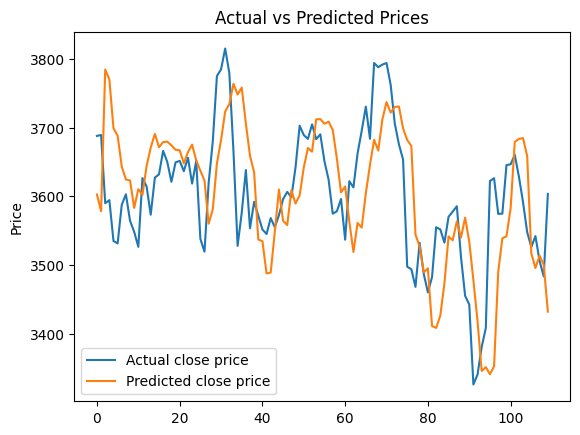

In [226]:
plt.plot(target_scaler.inverse_transform(test_targets.reshape(-1,1)), label='Actual close price')
plt.plot(np.array(pred_new).reshape(-1,1), label='Predicted close price')

plt.title('Actual vs Predicted Prices')
plt.ylabel('Price')
plt.legend()

plt.show()

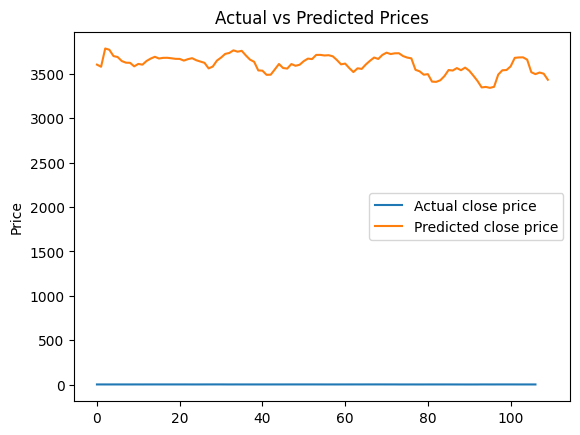

In [414]:
plt.plot(test_targets, label='Actual close price')
plt.plot(pred_new, label='Predicted close price')

plt.title('Actual vs Predicted Prices')
plt.ylabel('Price')
plt.legend()

plt.show()

In [ ]:
################

In [61]:
def convert_to_timesteps(array, timesteps=100):
    samples, features = array.shape
    output = np.zeros((samples, timesteps, features))

    for i in range(samples):
        start_idx = max(0, i - timesteps + 1)
        end_idx = i + 1
        window = array[start_idx:end_idx]
        output[i, -len(window):] = window

    return output



In [62]:
timesteps=100
X_train = convert_to_timesteps(X_train_scaled, timesteps=timesteps)
print(X_train.shape)

X_val = convert_to_timesteps(X_val_scaled, timesteps=timesteps)
X_val.shape

(973, 100, 10)


(215, 100, 10)

In [63]:
y_train = target_scaler.fit_transform(df_train["Next_Close"].values.reshape(-1, 1))
y_val=target_scaler.fit_transform(df_val["Next_Close"].values.reshape(-1, 1))

In [64]:

#timesteps = 1 
#X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], timesteps, X_train_scaled.shape[1]))
#X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], timesteps, X_test_scaled.shape[1]))

In [65]:
X_train.shape

(973, 100, 10)

Filter Value is :: 128


C:\Users\Divay Nagpal\anaconda3\envs\python310new1\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 96, 128)        │         6,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 48, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6144)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,528 (25.50 KB)

 Trainable params: 6,528 (25.50 KB)

 Non-trainable params: 0 (0.00 B)

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
mse :  4983599.881400151


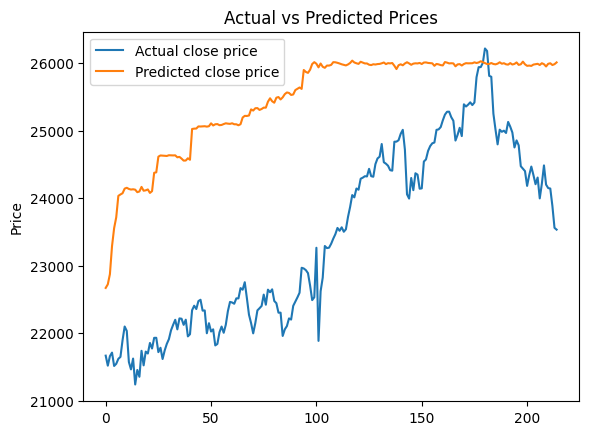

In [66]:
filter_vals=[128]
# For 1 layer
for filter_val in filter_vals:
    print("Filter Value is ::", filter_val)
    cnn_model = models.Sequential([
    Conv1D(filters=filter_val, kernel_size = 5, activation = 'relu', input_shape = (timesteps, X_train.shape[2])),
    MaxPooling1D(pool_size=2),
    Flatten(),
    ])
    cnn_model.summary()
    cnn_features = cnn_model.predict(X_train)
    xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)
    xgb_model.fit(cnn_features, y_train)
    predictions = xgb_model.predict(cnn_model.predict(X_val))
    mse = mean_squared_error(target_scaler.inverse_transform(y_val), target_scaler.inverse_transform(predictions.reshape(-1,1)))
    print("mse : ",mse)
    
    plt.plot(target_scaler.inverse_transform(y_val), label='Actual close price')
    plt.plot(target_scaler.inverse_transform(predictions.reshape(-1,1)), label='Predicted close price')
    
    plt.title('Actual vs Predicted Prices')
    plt.ylabel('Price')
    plt.legend()
    
    plt.show()